# Import python packages

In [48]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn
from sklearn import linear_model
from scipy.optimize import curve_fit
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, f1_score, confusion_matrix
from scipy import stats
import warnings
from sklearn.metrics import ConfusionMatrixDisplay
warnings.filterwarnings('ignore')
import matplotlib.colors as mcolors
from scipy.stats import lognorm
from utils import * 
import matplotlib.transforms as mtransforms

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.size'] = 12

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read data

In [49]:
data = pd.read_csv('aEQgate_geometries.csv')
feature = data["Feature"].unique()
grouped = data.groupby(data.Feature)

In [50]:
data.head()

FDHI ID   Earthquake          Date  Magnitude        Style  Hypocenter lat  \
0        4  Balochistan  '2013-09-24'        7.7  Strike-Slip          26.951   
1        4  Balochistan  '2013-09-24'        7.7  Strike-Slip          26.951   
2        4  Balochistan  '2013-09-24'        7.7  Strike-Slip          26.951   
3        4  Balochistan  '2013-09-24'        7.7  Strike-Slip          26.951   
4        4  Balochistan  '2013-09-24'        7.7  Strike-Slip          26.951   

   Hypocenter lon Feature Breached or unbreached  \
0          65.501    bend               breached   
1          65.501    bend               breached   
2          65.501    bend               breached   
3          65.501    bend               breached   
4          65.501    bend               breached   

  Type (releasing or restraining)  ... Length (m) or angle (deg)  \
0                             NaN  ...                 28.559781   
1                             NaN  ...                  7.664860   
2                             NaN  ...                  7.757706   
3                             NaN  ...                  9.379516   
4                             NaN  ...                  9.494918   

   Spacing double bend (m)  Type (length or angle)  Location along rupture  \
0                      0.0                   angle              919.999997   
1                      0.0                   angle             3529.999990   
2                      0.0                   angle             7669.999970   
3                      0.0                   angle            12099.999941   
4                      0.0                   angle            15129.999919   

  Total rupture length  Normalized location  Distance to epicenter  \
0        199115.277475             0.004620          159516.764576   
1        199115.277475             0.017728          156972.220664   
2        199115.277475             0.038520          153077.215326   
3        199115.277475             0.060769          148934.593509   
4        199115.277475             0.075986          146027.408927   

   Slip at gate (m)  Normalized slip at gate  UTM zone  
0          3.073435                 0.192090       41N  
1          4.169092                 0.260568       41N  
2          4.470297                 0.279394       41N  
3          7.988020                 0.499251       41N  
4          6.627956                 0.414247       41N  

[5 rows x 22 columns]

# Quickly play around with data
e.g. find largest restraining step-over

In [51]:
# data = pd.read_csv('aEQgate_geometries.csv')
# feature = data["Feature"].unique()
# grouped = data.groupby(data.Feature)
# grouped = grouped.get_group('bend')
# #restraining_rows = grouped[grouped["Type (releasing or restraining)"] == 'releasing']

# # # # # locations = grouped[grouped['Earthquake'] == 'Zirkuh'].index
# # # # # print(grouped.loc[locations, 'Length (m) or angle (deg)'])

# # # # # # # Filter rows where "Type (releasing or restraining)" is the type of interest
# restraining_rows = grouped[grouped["Type (single or double)"] == 'double']

# # # # # # # # Filter rows where "Breached or unbreached" is the type of interest
# breached_rows = restraining_rows[restraining_rows["Breached or unbreached"] == 'breached']
# max_length_or_angle = breached_rows["Length (m) or angle (deg)"].max()
# print(max_length_or_angle)
# # # # # # # # # Find location and value of the largest entry in "Length (m) or angle (deg)"
# # #max_length_or_angle = restraining_rows["Length (m) or angle (deg)"].max()
# largest_entry = breached_rows.loc[breached_rows["Length (m) or angle (deg)"].idxmax()]

# print(largest_entry)
# # # Find locations where the distance exceeds 2000

# plot and analyze data

### Earthquake gate distributions

log-normal distribution fitting of CDFs

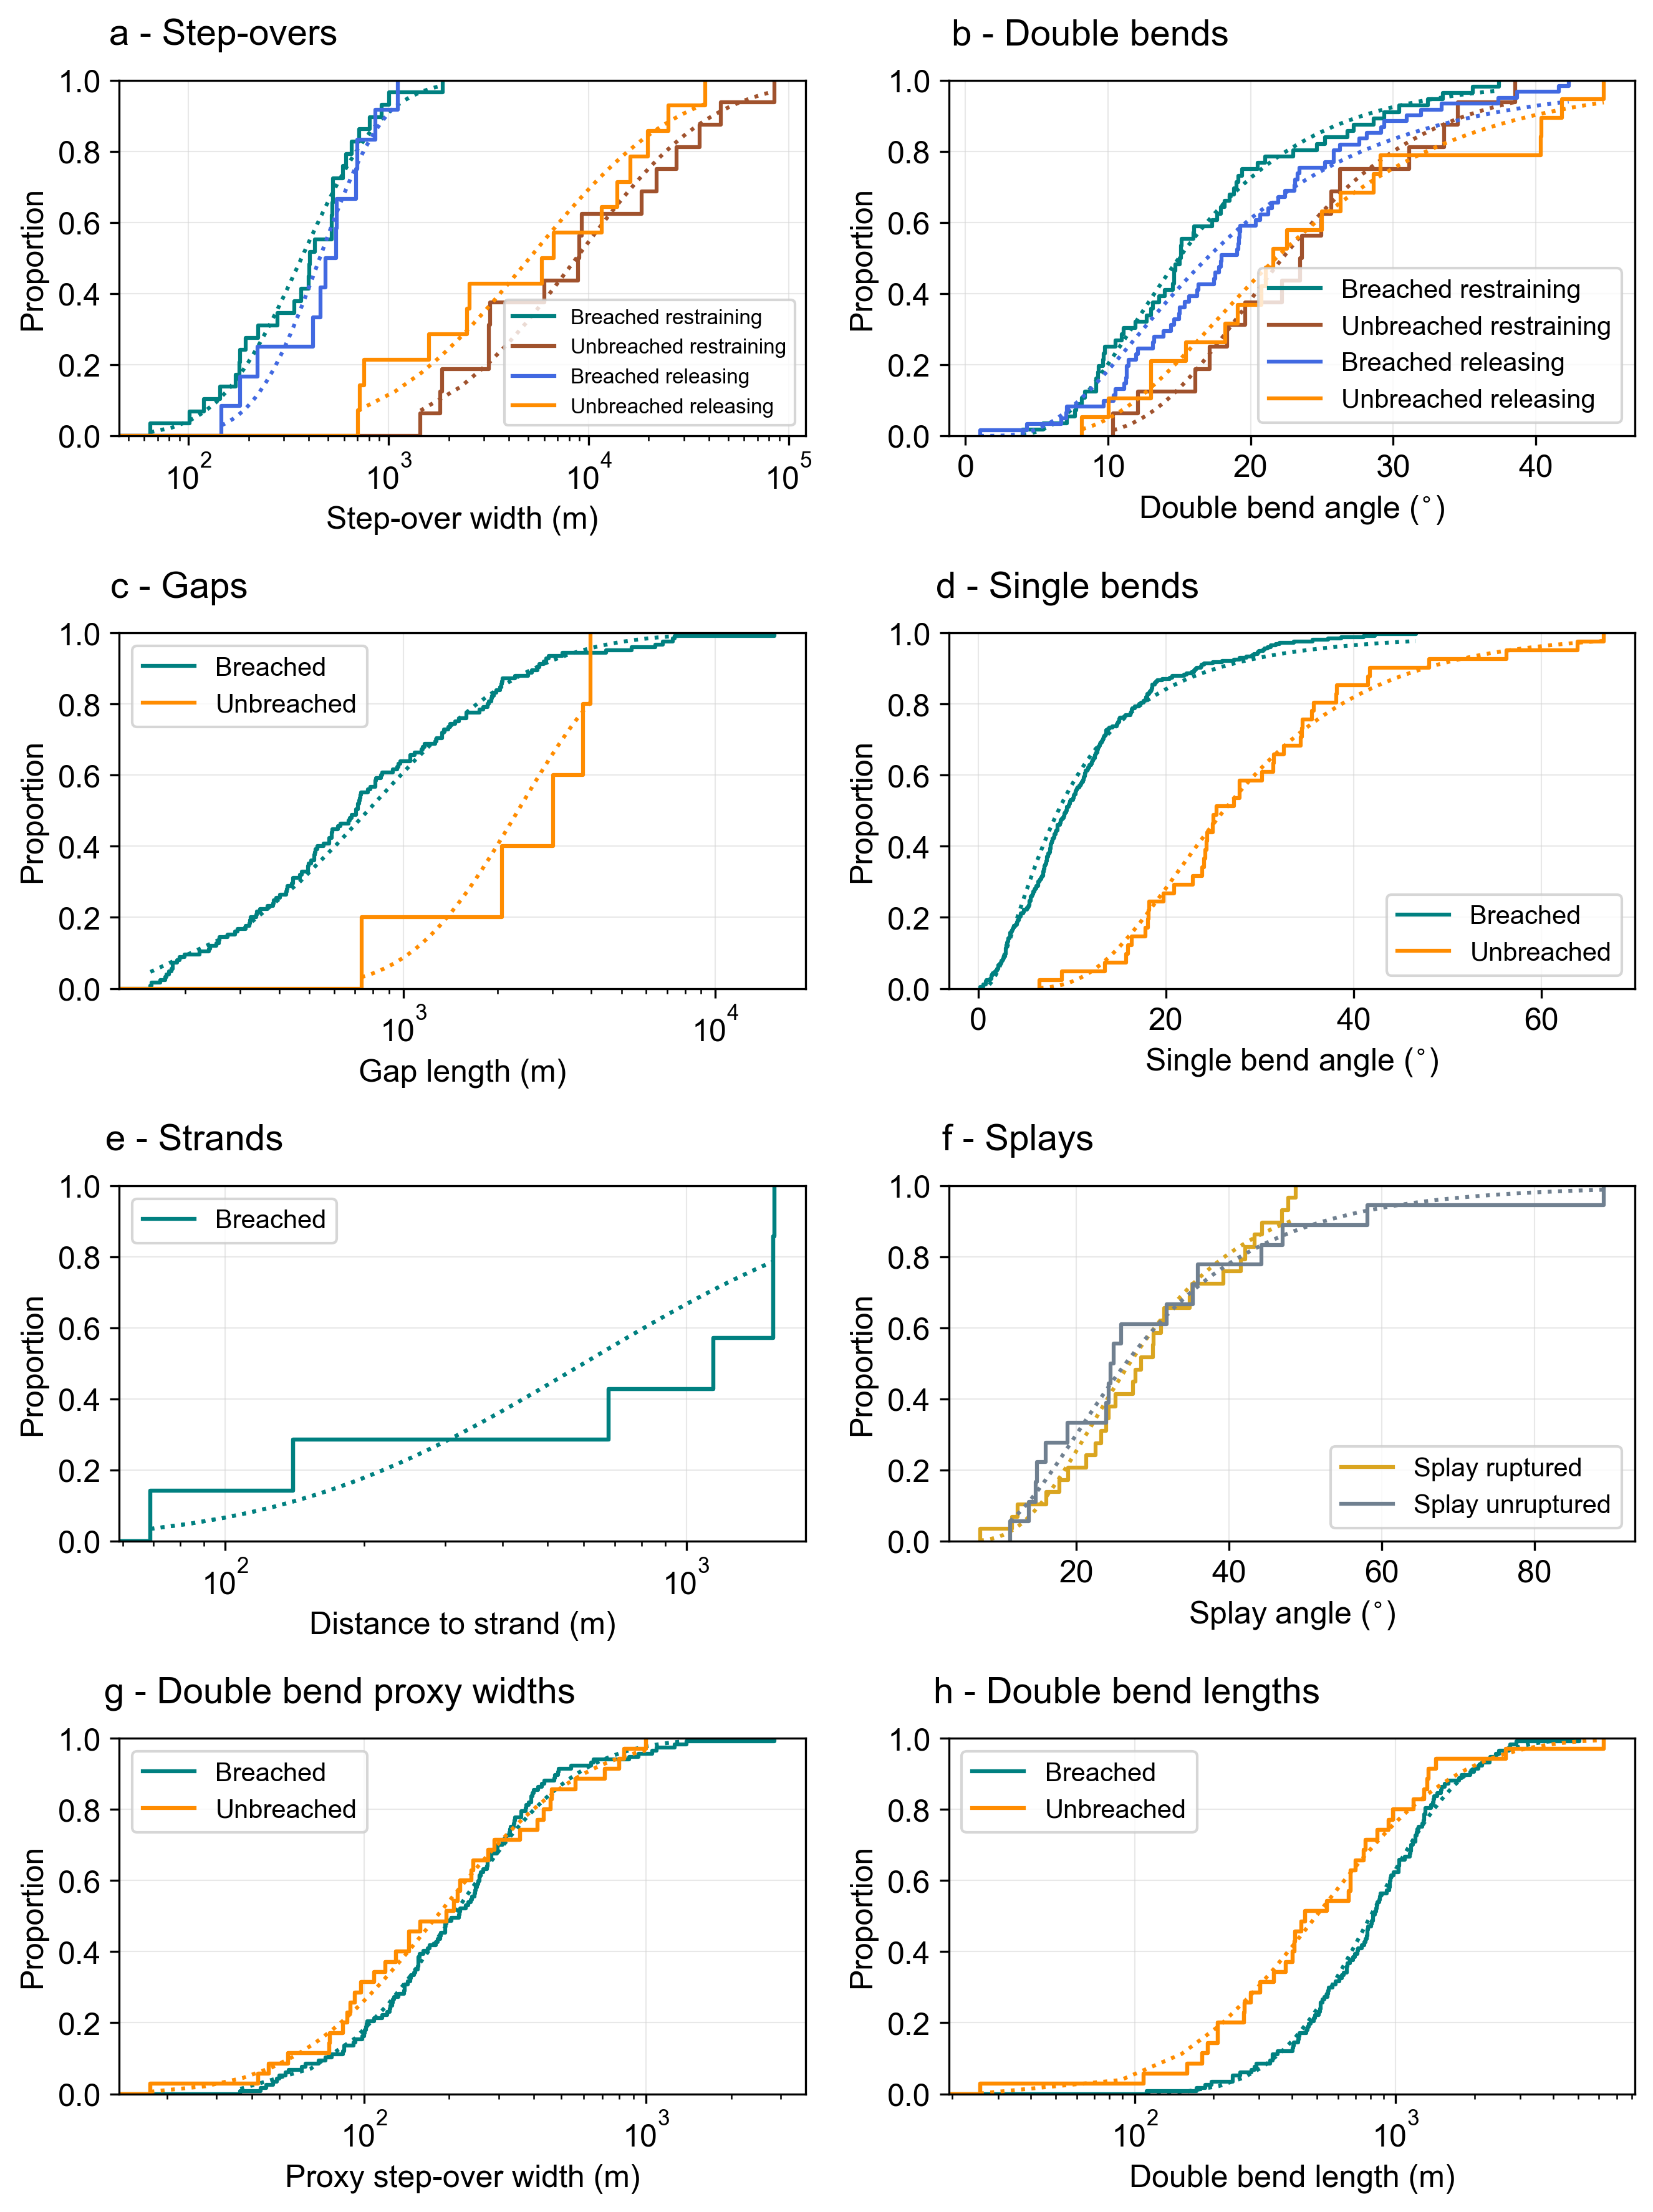

In [52]:
fig, axes = plt.subplots(4,2,figsize=(9,12),dpi=300)

build_cdf_lognorm(grouped,'stepover', 'restraining', 'length', 'teal','sienna',axes[0,0] ,'Step-over width (m)','Breached restraining', 'Unbreached restraining')
build_cdf_lognorm(grouped,'stepover', 'releasing', 'length', 'royalblue','darkorange',axes[0,0] , 'Step-over width (m)','Breached releasing', 'Unbreached releasing')
build_cdf_lognorm(grouped,'bend', 'restraining', 'angle','teal','sienna',axes[0,1] ,'Double bend angle ($^{\circ}$)','Breached restraining', 'Unbreached restraining')
build_cdf_lognorm(grouped,'bend', 'releasing', 'angle', 'royalblue','darkorange',axes[0,1] ,'Double bend angle ($^{\circ}$)','Breached releasing', 'Unbreached releasing')
build_cdf_lognorm(grouped,'gap', 'none', 'length', 'teal','darkorange',axes[1,0] , 'Gap length (m)','Breached', 'Unbreached')
build_cdf_lognorm(grouped,'bend', 'single', 'angle', 'teal','darkorange',axes[1,1] ,'Single bend angle ($^{\circ}$)','Breached', 'Unbreached')
build_cdf_lognorm(grouped,'splay', 'none', 'angle', 'goldenrod','slategrey',axes[2,1] ,'Splay angle ($^{\circ}$)','Splay ruptured', 'Splay unruptured')
build_cdf_lognorm(grouped,'strand', 'none', 'length', 'teal','teal',axes[2,0] ,'Distance to strand (m)','Breached', '')
build_cdf_bend_lengths(grouped,'bend', 'double', 'Distance splay or double bend (m)', 'teal','darkorange',axes[3,1],'Double bend length (m)','Breached', 'Unbreached')
build_cdf_bend_lengths(grouped,'bend', 'double', 'Spacing double bend (m)', 'teal','darkorange',axes[3,0],'Proxy step-over width (m)','Breached', 'Unbreached')

# labels
axes[0,0].text(40,1.1,'a - Step-overs',fontsize=14)
axes[0,1].text(-1,1.1,'b - Double bends',fontsize=14)
axes[1,0].text(115,1.1,'c - Gaps',fontsize=14)
axes[1,1].text(-4.5,1.1,'d - Single bends',fontsize=14)
axes[2,0].text(55,1.1,'e - Strands',fontsize=14)
axes[2,1].text(2.5,1.1,'f - Splays',fontsize=14)
axes[3,1].text(17,1.1,'h - Double bend lengths',fontsize=14)
axes[3,0].text(12,1.1,'g - Double bend proxy widths',fontsize=14)

plt.tight_layout()
plt.savefig('GRL/lognorm_CDFs.pdf')
plt.show()


ks tests

In [53]:
# ks test for populations of earthquake gates
double_bend_ks = kstest_variables(grouped,'bend', 'double', 'angle')
print('double_bend_ks')
print(double_bend_ks)

single_bend_ks = kstest_variables(grouped,'bend', 'single', 'angle')
print('single_bend_ks')
print(single_bend_ks)

stepover_ks= kstest_variables(grouped,'stepover', 'none', 'length')
print('stepover_ks')
print(stepover_ks)

gap_ks = kstest_variables(grouped,'gap', '', 'length')
print('gap_ks')
print(gap_ks)

splay_ks = kstest_variables(grouped,'splay', 'none', 'angle')
print('splay_ks')
print(splay_ks)

releasing_restraining_unbreached_bend_ks = kstest_variables(grouped,'bend', 'releasing_restraining_unbreached', 'angle')
print('releasing_restraining_unbreached_bend_ks')
print(releasing_restraining_unbreached_bend_ks)

releasing_restraining_breached_bend_ks = kstest_variables(grouped,'bend', 'releasing_restraining_breached', 'angle')
print('releasing_restraining_breached_bend_ks')
print(releasing_restraining_breached_bend_ks)

releasing_restraining_breached_stepover_ks = kstest_variables(grouped,'stepover', 'releasing_restraining_breached', 'length')
print('releasing_restraining_breached_stepover_ks')
print(releasing_restraining_breached_stepover_ks)

releasing_restraining_unbreached_stepover_ks = kstest_variables(grouped,'stepover', 'releasing_restraining_unbreached', 'length')
print('releasing_restraining_unbreached_stepover_ks')
print(releasing_restraining_unbreached_stepover_ks)

double_bend_ks
KstestResult(statistic=0.32405372405372407, pvalue=0.005049230707324361, statistic_location=18.1651820573246, statistic_sign=1)
single_bend_ks
KstestResult(statistic=0.696360518292683, pvalue=2.6794066187000626e-17, statistic_location=15.6935103227513, statistic_sign=1)
stepover_ks
KstestResult(statistic=0.875609756097561, pvalue=2.3400308591146145e-14, statistic_location=3.0474932286774465, statistic_sign=1)
gap_ks
KstestResult(statistic=0.664, pvalue=0.014188563527054648, statistic_location=3.3156138688628625, statistic_sign=1)
splay_ks
KstestResult(statistic=0.19731800766283525, pvalue=0.6938316758450852, statistic_location=25.8837228358785, statistic_sign=-1)
releasing_restraining_unbreached_bend_ks
KstestResult(statistic=0.21052631578947367, pvalue=0.7370006073628456, statistic_location=38.5537988009005, statistic_sign=-1)
releasing_restraining_breached_bend_ks
KstestResult(statistic=0.20608899297423888, pvalue=0.14025959448606487, statistic_location=19.018789913614

# Plot passing probabilities and earthquake gate analysis

Logistic models

In [54]:
fig, axes = plt.subplots(2,2,figsize=(8,8), sharey=True, dpi=300)
 
log_stepover, acc_stepover, pre_stepover, f1_stepover, roc_stepover, confusion_matrix_stepover, BUbin_stepover,xstepover = build_logistic_regression(
    grouped,
    'stepover', 
    'none', 
    'length', 
    None, 
    axes[0,0],
    50,
    100000,
    'slategrey',
    'Step-over width (m)',
    5
)

log_bend_double, acc_bend_double, pre_bend_double, f1_bend_double, roc_bend_double, confusion_matrix_bend_double,BUbin_bend_double,xbenddouble= build_logistic_regression(grouped,'bend', 'double', 'angle',None,axes[0,1],0,90,'slategrey','Double bend angle ($^{\circ}$)',2.5)
log_bend_single, acc_bend_single, pre_bend_single, f1_bend_single, roc_bend_single, confusion_matrix_bend_single,BUbin_bend_single,xbendsingle = build_logistic_regression(grouped,'bend', 'single', 'angle', None,
                                                                                                                                                                           axes[1,1],0,90,'slategrey','Single bend angle ($^{\circ}$)',2.5)

log_gap, acc_gap, pre_gap, f1_gap, roc_gap, confusion_matrix_gap, BUbin_gap,xgap = build_logistic_regression(grouped,'gap', 'none', 'length', None, axes[1,0],50,100000,'slategrey','Gap length (m)',3)


# labels
axes[0,0].text(50,-0.3,'a - Step-overs',fontsize=14)
axes[0,1].text(0,-0.3,'b - Double bends',fontsize=14)
axes[1,0].text(50,-0.3,'c - Gaps',fontsize=14)
axes[1,1].text(0,-0.3,'d - Single bends',fontsize=14)

plt.tight_layout()
plt.savefig('GRL/PP_EQgates.pdf')
plt.show()

logistic regression for releasing and restraining subgroups

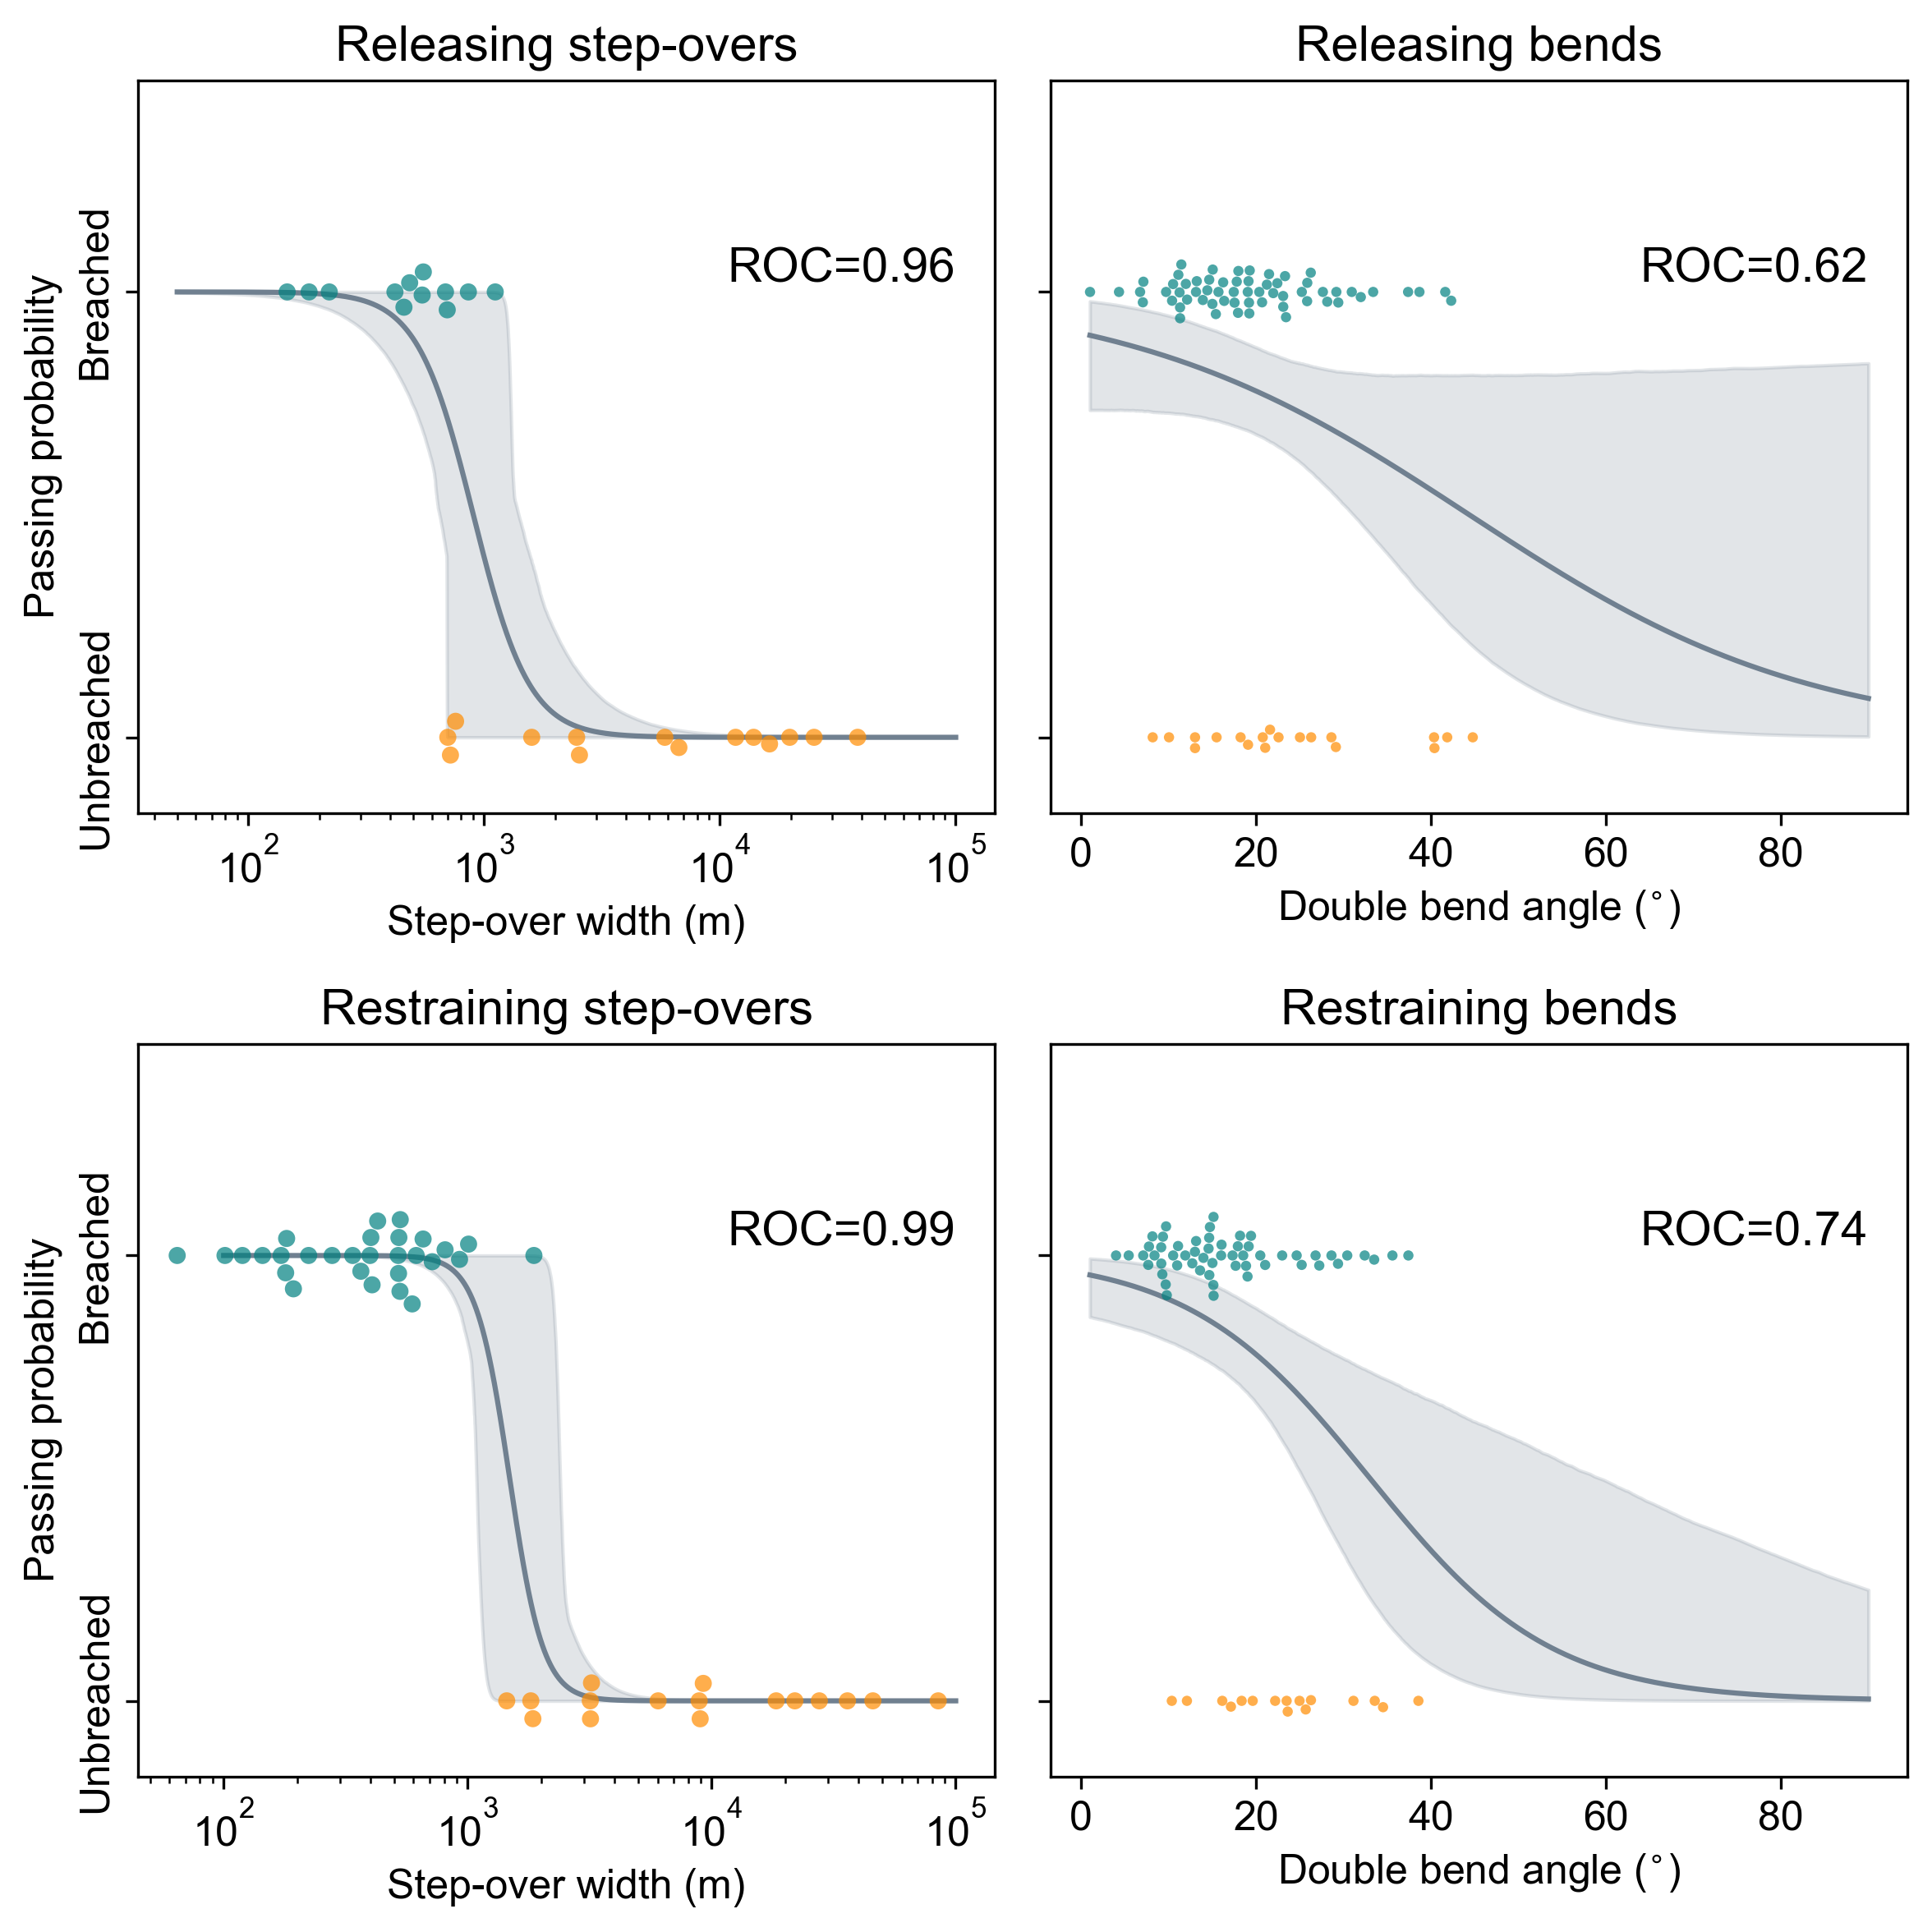

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(8,8), sharey=True, dpi=300)
 
build_logistic_regression(
    grouped,
    'stepover', 
    'releasing', 
    'length', 
    None, 
    axes[0,0],
    50,
    100000,
    'slategrey',
    'Step-over width (m)',
    5
)

build_logistic_regression(grouped,'bend', 'releasing', 'angle', None,
                         axes[0,1],1,90,'slategrey','Double bend angle ($^{\circ}$)',3)
build_logistic_regression(grouped,'bend', 'restraining', 'angle', None, 
                         axes[1,1],1,90,'slategrey','Double bend angle ($^{\circ}$)',3)
build_logistic_regression(grouped,'stepover', 'restraining', 'length', None, 
                          axes[1,0],100,100000,'slategrey','Step-over width (m)',5)

axes[0,0].set_title('Releasing step-overs')
axes[0,1].set_title('Releasing bends')
axes[1,1].set_title('Restraining bends')
axes[1,0].set_title('Restraining step-overs')

plt.tight_layout()
plt.savefig('GRL/PP_EQgates_RR_categories.pdf')
plt.show()

Predict probability for earthquake gate of given geometry based on logistic model for that type of earthquake gate

In [ ]:
#x = np.atleast_2d(25).T
x = np.atleast_2d(np.log10(24500)).T
proba = log_gap.predict_proba(x)[:,0]
proba

array([0.5046355])

Let's assess the quality of the logistic regressions. 

In [ ]:
print("ROC step-over",roc_stepover)
print("ROC single bend",roc_bend_single)
print("ROC double bend",roc_bend_double)
print("ROC gap",roc_gap)

ROC step-over 0.9813008130081301
ROC single bend 0.8913871951219512
ROC double bend 0.6813186813186813
ROC gap 0.8480000000000001


### double bend/step-over proxy analysis

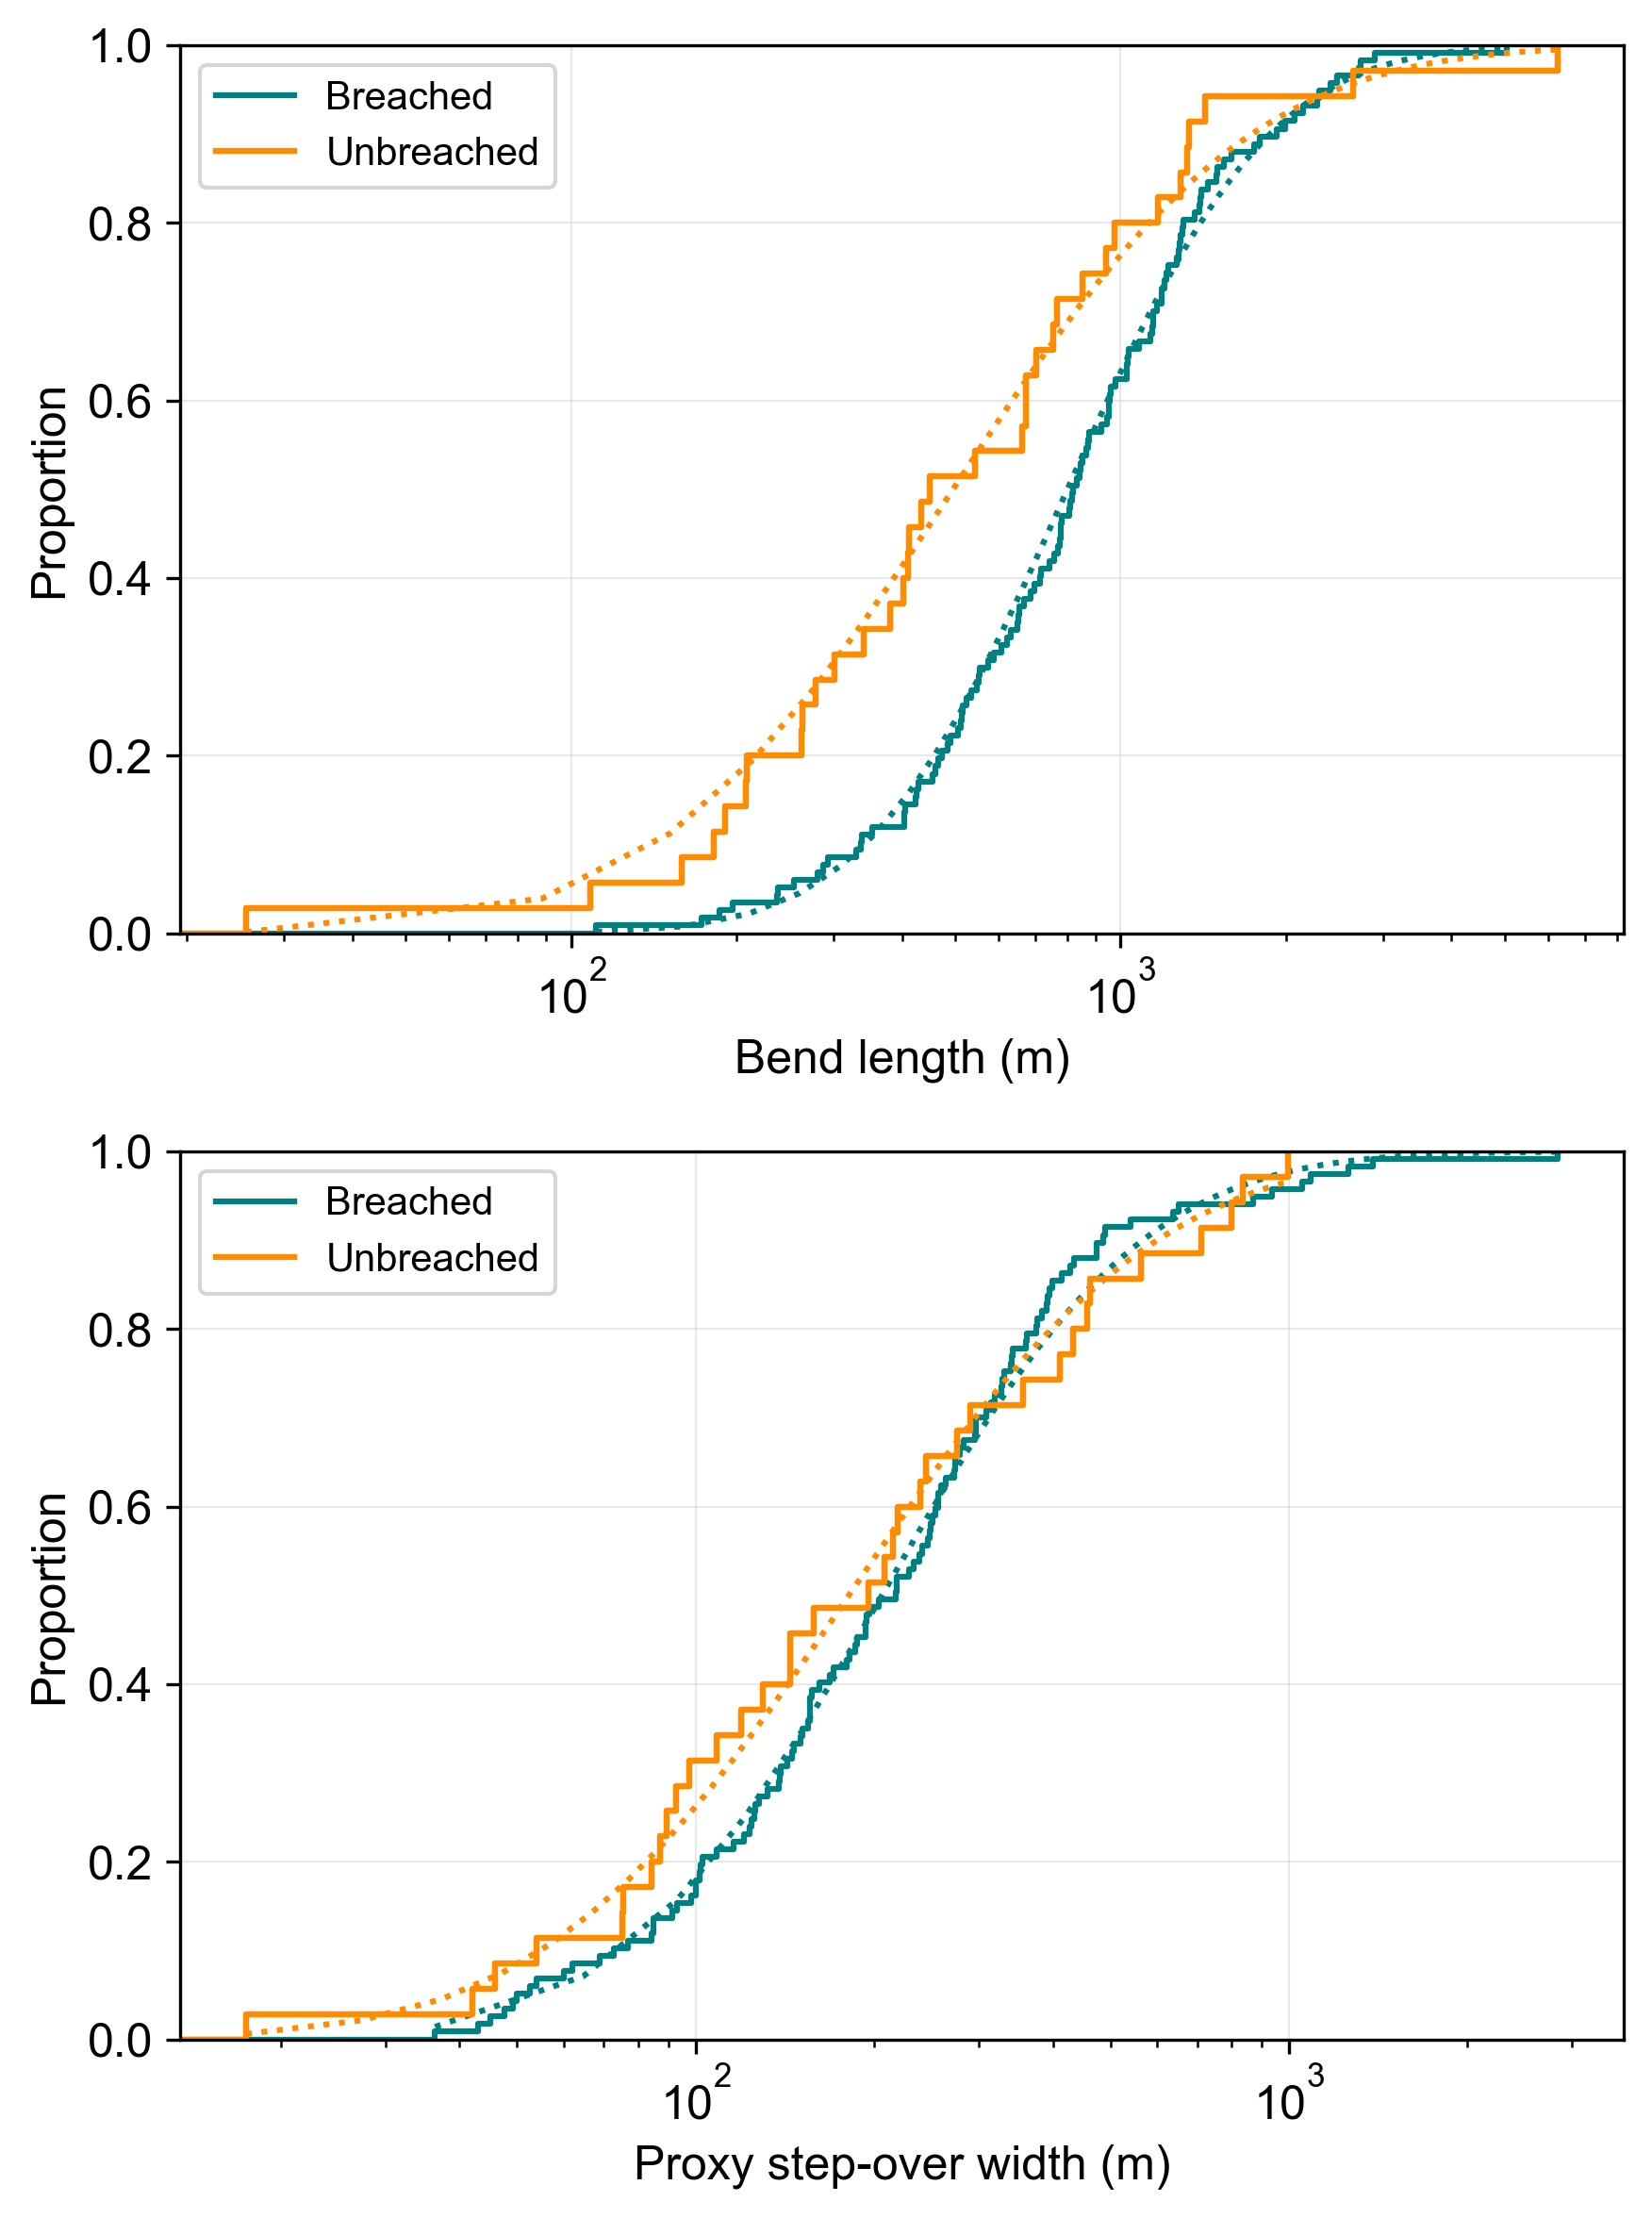

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(6,8), dpi=300)
build_cdf_bend_lengths(grouped,'bend', 'double', 'Distance splay or double bend (m)', 'teal','darkorange',ax[0],'Bend length (m)','Breached', 'Unbreached')
build_cdf_bend_lengths(grouped,'bend', 'double', 'Spacing double bend (m)', 'teal','darkorange',ax[1],'Proxy step-over width (m)','Breached', 'Unbreached')
plt.tight_layout()
plt.savefig('GRL/bend_length_CDFs.pdf')

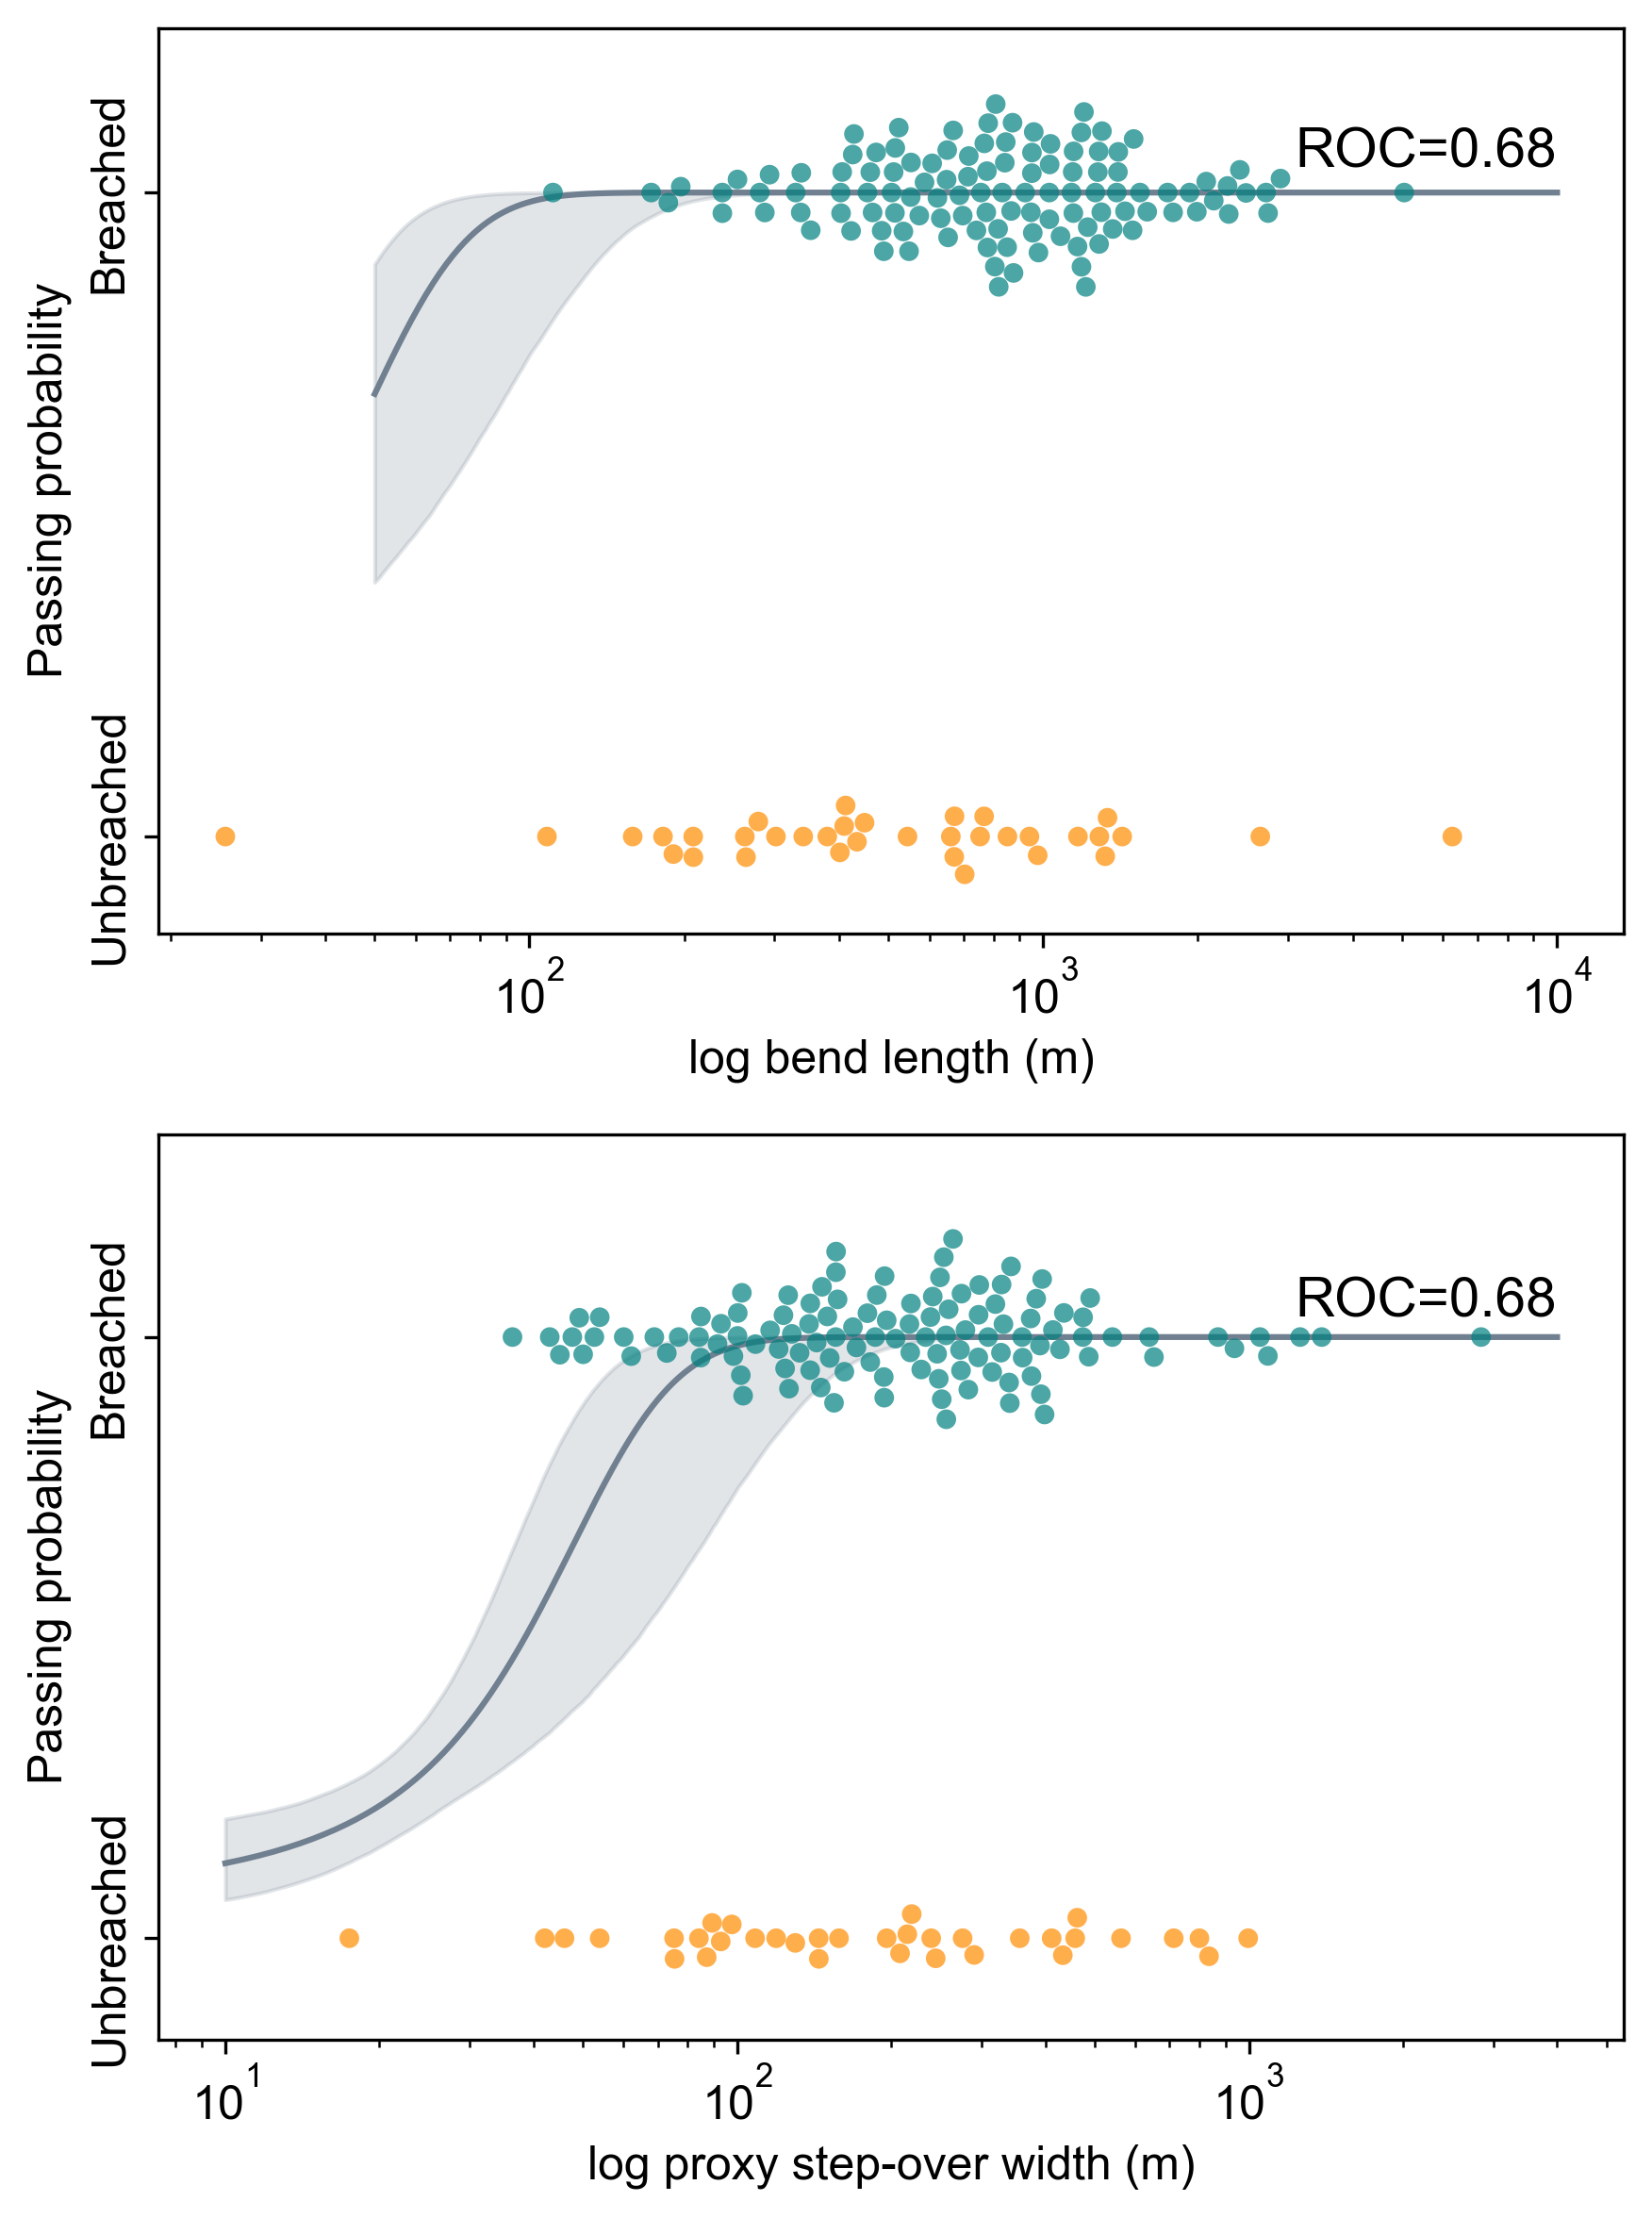

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(6,8), dpi=300)
build_regression_double_bend_length(grouped,'bend', 'double', 'Distance splay or double bend (m)',ax[0],50,10000,'log bend length (m)',5)
build_regression_double_bend_length(grouped,'bend', 'double', 'Spacing double bend (m)',ax[1],10,4000,'log proxy step-over width (m)',5)
plt.tight_layout()
plt.savefig('GRL/bend_lengths.pdf.pdf')

Confusion matrices to evaluate logistic model fit

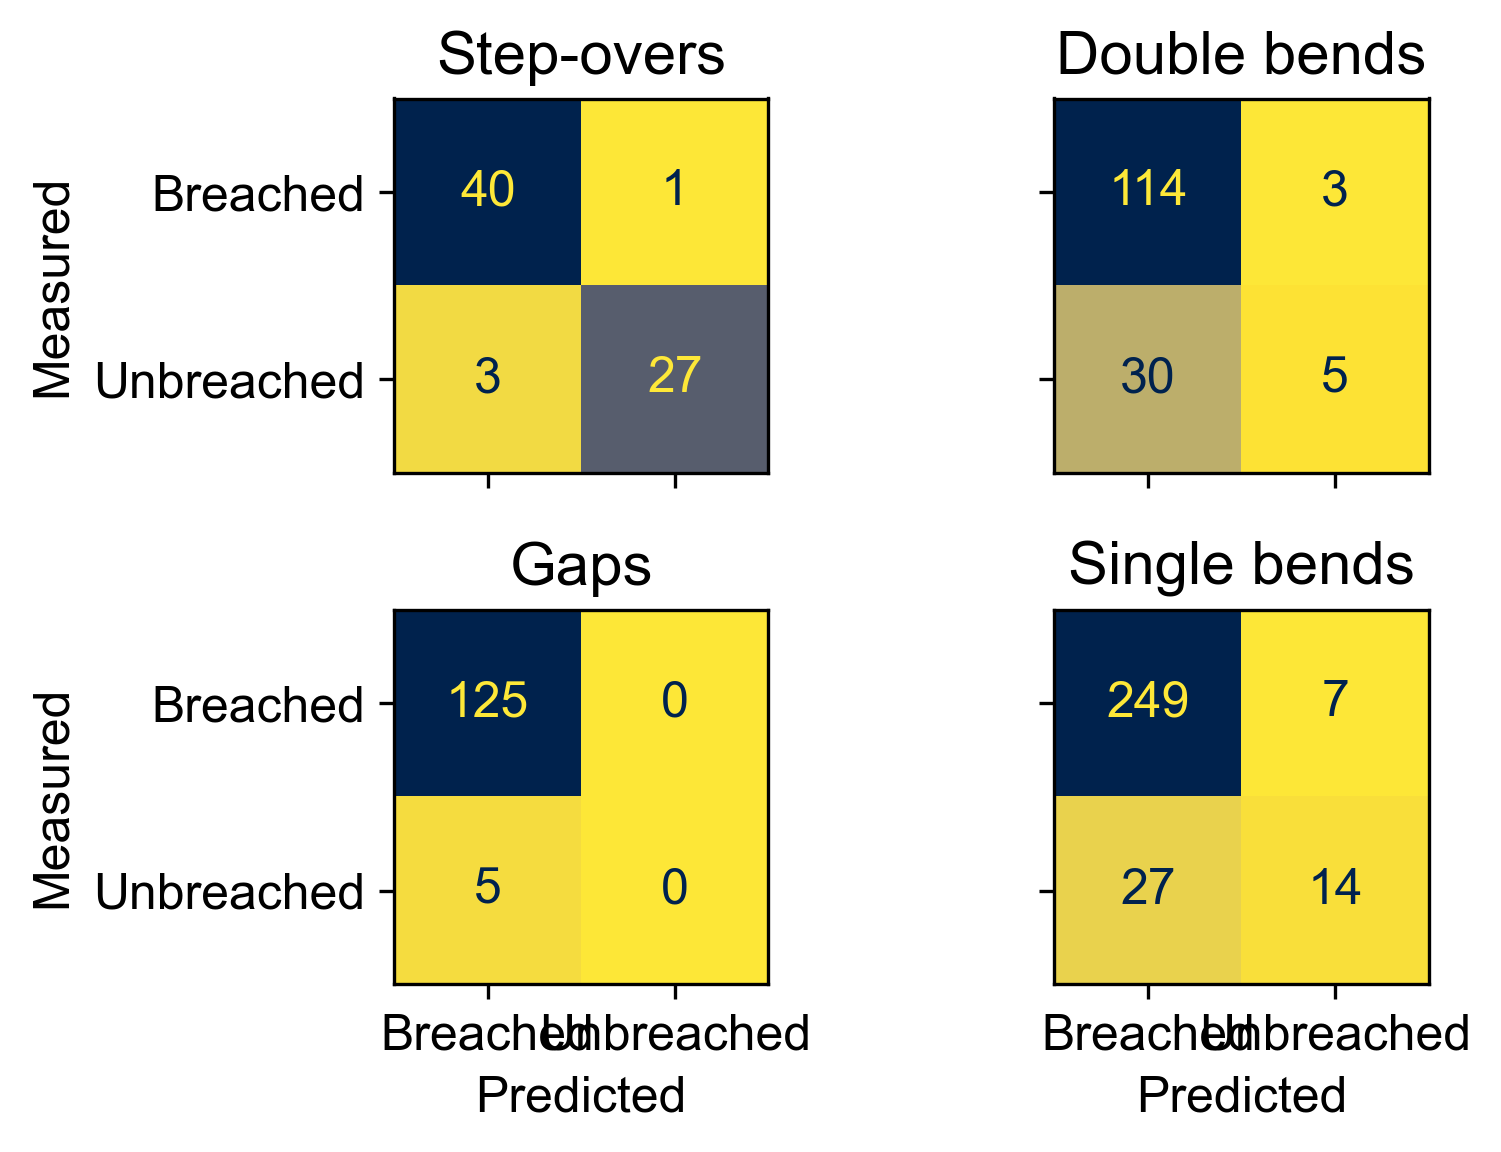

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(6,4), dpi=300,sharex=True,sharey=True)


# getting the original colormap using cm.get_cmap() function
orig_map=plt.cm.get_cmap('cividis')
labels = ['Breached', 'Unbreached']
  
# reversing the original colormap using reversed() function
reversed_map = orig_map.reversed()

disp_stepover = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_stepover,display_labels=labels)
disp_stepover.plot(cmap=reversed_map, include_values=True,colorbar=False,ax = axes[0,0])
axes[0,0].set_title('Step-overs')
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('Measured')

disp_double_bend = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_bend_double,display_labels=labels)
disp_double_bend.plot(cmap=reversed_map, include_values=True,colorbar=False,ax = axes[0,1])
axes[0,1].set_title('Double bends')
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('')

disp_double_single = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_bend_single,display_labels=labels)
disp_double_single.plot(cmap=reversed_map, include_values=True,colorbar=False,ax = axes[1,1])
axes[1,1].set_title('Single bends')
axes[1,1].set_xlabel('Predicted')
axes[1,1].set_ylabel('')

disp_gap = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_gap,display_labels=labels)
disp_gap.plot(cmap=reversed_map, include_values=True,colorbar=False,ax = axes[1,0])
axes[1,0].set_title('Gaps')
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('Measured')

plt.tight_layout()
plt.savefig('GRL/confusion_matrices.pdf')
plt.show()

# Analysis of earthquake likelihood and surface rupture length

Extract passing probability for all mapped gates based on logistic models:
-- Note gaps, splays (statiscally indifferent), and strands are all assigned probabilities of 1 given the do not influence rupture propagation

In [ ]:
fun_dict = {
    'log_stepover' : log_stepover,  
    'log_bend_single': log_bend_single,
    'log_bend_double':log_bend_double,
    'log_gap': log_gap
}

passing_probability_gate = []

for i in range(len(data)): 
    datai = data.iloc[i]
    featurei = datai['Feature']
    RRi = datai['Type (releasing or restraining)']

    if featurei == 'bend':
        RRi = datai['Type (releasing or restraining)']
        RRstr = str(RRi)

        if RRstr == 'nan':
            name_select = 'log' + '_' + 'bend' + '_' + 'single'
            extract = fun_dict[name_select]
            x = np.atleast_2d(datai['Length (m) or angle (deg)']).T
            PRi  = extract.predict_proba(x)[:,0]

        else:
            name_select = 'log' + '_' + 'bend' + '_' + 'double'
            extract = fun_dict[name_select]
            x = np.atleast_2d(datai['Length (m) or angle (deg)']).T
            PRi  = extract.predict_proba(x)[:,0]

    # elif featurei == 'gap':
    #     strlog = 'log'
    #     name_select = strlog + '_' + 'gap' 
    #     extract = fun_dict[name_select]
    #     x = np.atleast_2d(datai['Length (m) or angle (deg)']).T
    #     PRi  = extract.predict_proba(np.log10(x))[:,0]

    elif featurei == 'stepover': 
        featurestr = str(featurei)
        strlog = 'log'
        RRstr = str(RRi)
        name_select = strlog + '_' + featurestr 
        extract = fun_dict[name_select]
        x = np.atleast_2d(datai['Length (m) or angle (deg)']).T
        PRi  = extract.predict_proba(np.log10(x))[:,0]
    
    else:
        PRi = 1
        

    passing_probability_gate.append(PRi)

data['passing_probability_gate'] = passing_probability_gate


Calculate earthquake likelihood for each event based on the previously estimated probabilities for each earthquake gate

In [ ]:
event = data["Earthquake"]
event.unique()

mag = np.array([])
event_likelihood = np.array([])
event_group = event.unique()
SRL = np.array([])

for EQ in event_group:
    subset = data.loc[data['Earthquake'] == EQ]
    subsetb = subset.loc[subset['Breached or unbreached'] == "breached"]
    mag_i = subsetb['Magnitude']
    mag_i = mag_i.iloc[0]
    SRLi = subsetb['Total rupture length']
    SRLi = SRLi.iloc[0]

    subsetb['passing_probability_gate'] = subsetb['passing_probability_gate'].astype(float)
    subsetb['passing_probability_gate_log'] = np.log(subsetb['passing_probability_gate'])   
    event_likelihood_i = np.sum(subsetb['passing_probability_gate_log'])

    print(mag_i,EQ,event_likelihood_i,SRLi)

    event_likelihood = np.append(event_likelihood, event_likelihood_i)
    mag = np.append(mag,mag_i)
    SRL = np.append(SRL,SRLi)

7.7 Balochistan -7.5466048984054215 199115.277475184
6.63 Borrego -3.815360792788369 31546.4857015686
6.19 ChalfantValley -0.3031210444579671 14207.5427349576
7.0 Darfield -1.7945281633881902 28896.3939931895
7.9 Denali -7.556498324661522 278702.916265388
7.14 Duzce -2.7024138463608662 40018.847231306
6.22 ElmoreRanch -0.3275065838091435 8899.97956202332
5.2 GalwayLake -0.5713604649195492 6900.28452126802
7.13 HectorMine -3.1310794264286703 48174.1492813072
6.4 Hualien -0.6394778899495291 7305.71812073165
6.95 Imperial1940 -0.5155741106153637 60614.751301348
6.53 Imperial1979 -2.1353160090062744 32653.1156479598
7.51 Izmit_Kocaeli -2.4473823663922007 121770.934867524
6.5 IzuPeninsula -0.33932957347654646 5501.24642743068
6.9 Kobe -0.5760901700800416 10101.7645342178
7.0 Kumamoto -2.053250235748881 31578.8204966148
7.28 Landers -5.297956548814243 84722.12096402
7.7 Luzon -8.5370960987173 117824.691193508
6.0 Napa -1.1317332796721566 22219.9745137025
7.0 Neftegorsk -0.9922891436346403 38

In [ ]:
# probability of stopping on straight segment 
n_ends_no_gates = 16
total_SRL = np.sum(SRL)
p_straight = n_ends_no_gates/total_SRL
p_continue_straight = 1-p_straight

In [ ]:
p_straight

1.0046503300927886e-05

ValueError: '-o' is not a valid value for ls; supported values are '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'

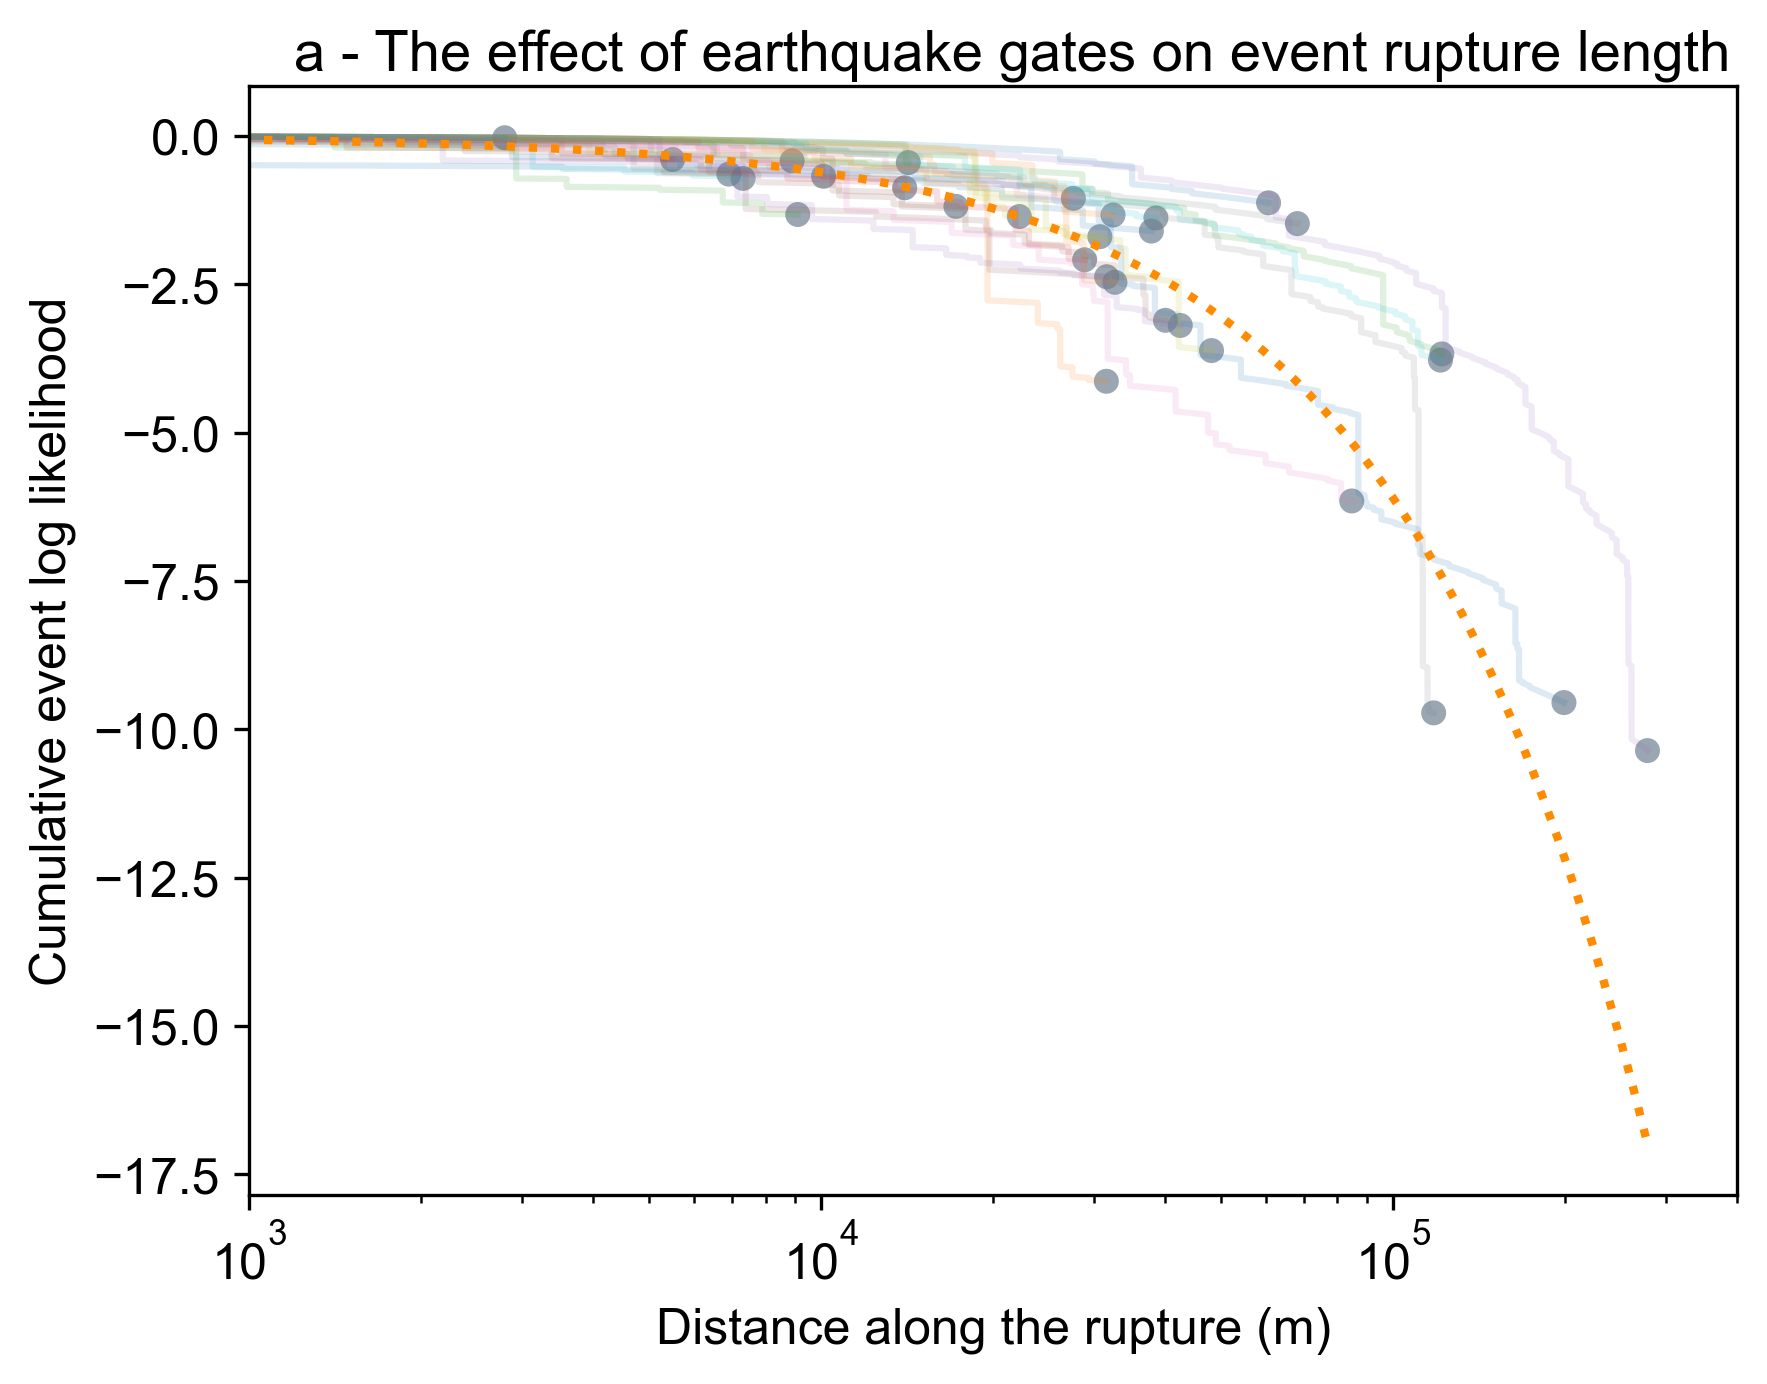

In [ ]:
######################################################## cumulative probability

lastpt = [] # last point on surface rupture or total surface rupture length
keeplikelihood = event_likelihood+np.log(p_continue_straight)*(SRL-len(event_likelihood)) # final event likelihood

# cumulative event likelihood:
plt.figure(dpi=300)
for EQ in event_group:
    subset = data.loc[data['Earthquake'] == EQ]
    subsetb = subset.loc[subset['Breached or unbreached'] == "breached"]
    subsetb = subsetb.reset_index(drop=True)
    subsetb['passing_probability_gate'] = subsetb['passing_probability_gate'].astype(float)

    gatelikelihood = subsetb['passing_probability_gate']
    gateloglikelihood = np.log(subsetb['passing_probability_gate'])
    
    gateloc = subsetb['Location along rupture']
    subsetb['Approx_Location'] = subsetb['Location along rupture'].round().astype(int)

    SRL_event = subsetb['Total rupture length']   
    surf_length = SRL_event[0]
    surf_length = round(surf_length)
    probframe = pd.DataFrame()
    SRL_points = list(range(surf_length))
    new_rows = pd.DataFrame({'surf_length': SRL_points})
    probframe = probframe.append(new_rows, ignore_index=True)
    probframe['prob_straight_segment'] = p_continue_straight
    merged_df = pd.merge(probframe, subsetb, left_on='surf_length', right_on='Approx_Location', how='left')
    merged_df['prob'] = merged_df.apply(lambda row: row['passing_probability_gate'] if not pd.isnull(row['passing_probability_gate']) else row['prob_straight_segment'], axis=1)
    merged_df['cumulative_sum'] = np.log(merged_df['prob']).cumsum()

    lastpt.append(max(SRL_points))

    sns.lineplot(data=merged_df,x=merged_df['surf_length'],y=merged_df['cumulative_sum'],palette="blend:#7AB,#EDA",alpha=0.15) 

plt.scatter(lastpt,keeplikelihood,c='slategrey',edgecolor='none',alpha=0.7,label='Likelihood at final rupture length',linewidth=1.3)
lastpt = np.array(lastpt) # for fitting model later
keeplikelihood = np.array(keeplikelihood)

plt.ylabel('Cumulative event log likelihood')
plt.xlabel('Distance along the rupture (m)')
plt.xlim([10**3, 400*10**3])

# fit exponential relationship through modeled final event likelihoods
y = np.array(keeplikelihood)
slope = np.mean(y / lastpt)
x_range = np.linspace(1, max(lastpt), 1000)
y_range = slope * x_range + 0

# standard error on the slope
predicted_y =  slope * lastpt + 0
residuals = y - predicted_y
SSR = np.sum(residuals**2)
var_x = np.var(lastpt)
SE_slope = np.sqrt(SSR / ((len(lastpt) - 2) * np.sum((lastpt - np.mean(lastpt))**2)))

plt.plot(x_range, y_range, label='Expectation from best fit to event log likelihoods', linestyle=':',linewidth=2,c='darkorange')
plt.xscale('log')

plt.tick_params(axis='x', labelsize=12)
plt.text(1200,1.1,'a - The effect of earthquake gates on event rupture length',fontsize=13.5)

# bracketing for understanding role of characteristic length scale
# x0_low = 10**4
# x0_high = 10**5
# y0 = np.log(np.exp(-x_range/x0_low))
# y1 = np.log(np.exp(-x_range/x0_high))

# plt.fill_between(x_range,y0,y1,color='firebrick',alpha=0.1)

# add Gutenberg-Richter prediction
GR_ratio = np.log10(np.array([1, 0.246, 0.110, 0.062, 0.040, 0.028, 0.020, 0.016, 0.012]))  # from Biasi and Wesnousky, 2021
SRL_GR = np.array([7, 14, 21, 28, 35, 42, 49, 56, 63])  # from Biasi and Wesnousky, 2021
# fit pwl through GR data in Table 1 of Biasi and Wesnousky, 2021
popt, pcov = curve_fit(power_law, SRL_GR*10**3, GR_ratio)
xfit = np.linspace(min(SRL_GR*10**3),max(lastpt), 10000)
yfit = power_law(xfit, *popt)
lgnd_string = r'Expectation from Gutenberg-Richter distribution' + '\n' + 'of rupture length (Biasi and Wesnousky, 2021)'
plt.plot(xfit, yfit, label=lgnd_string,linestyle='-.',linewidth=2,c='black')

# add straight fault prediction
SRL_range = np.linspace(1000,3*10**5)
p_straight_fault = np.log(p_continue_straight)*SRL_range
plt.plot(SRL_range, p_straight_fault, label='Expectation for a straight fault with no earthquake gates', linestyle='-',linewidth=2,c='teal')
plt.legend(fontsize=10)
plt.ylim(-10.8,0.5)
plt.tight_layout()
plt.savefig('GRL/SRL_likelihood.pdf')
plt.show()

# Earthquake gates along rupture analysis

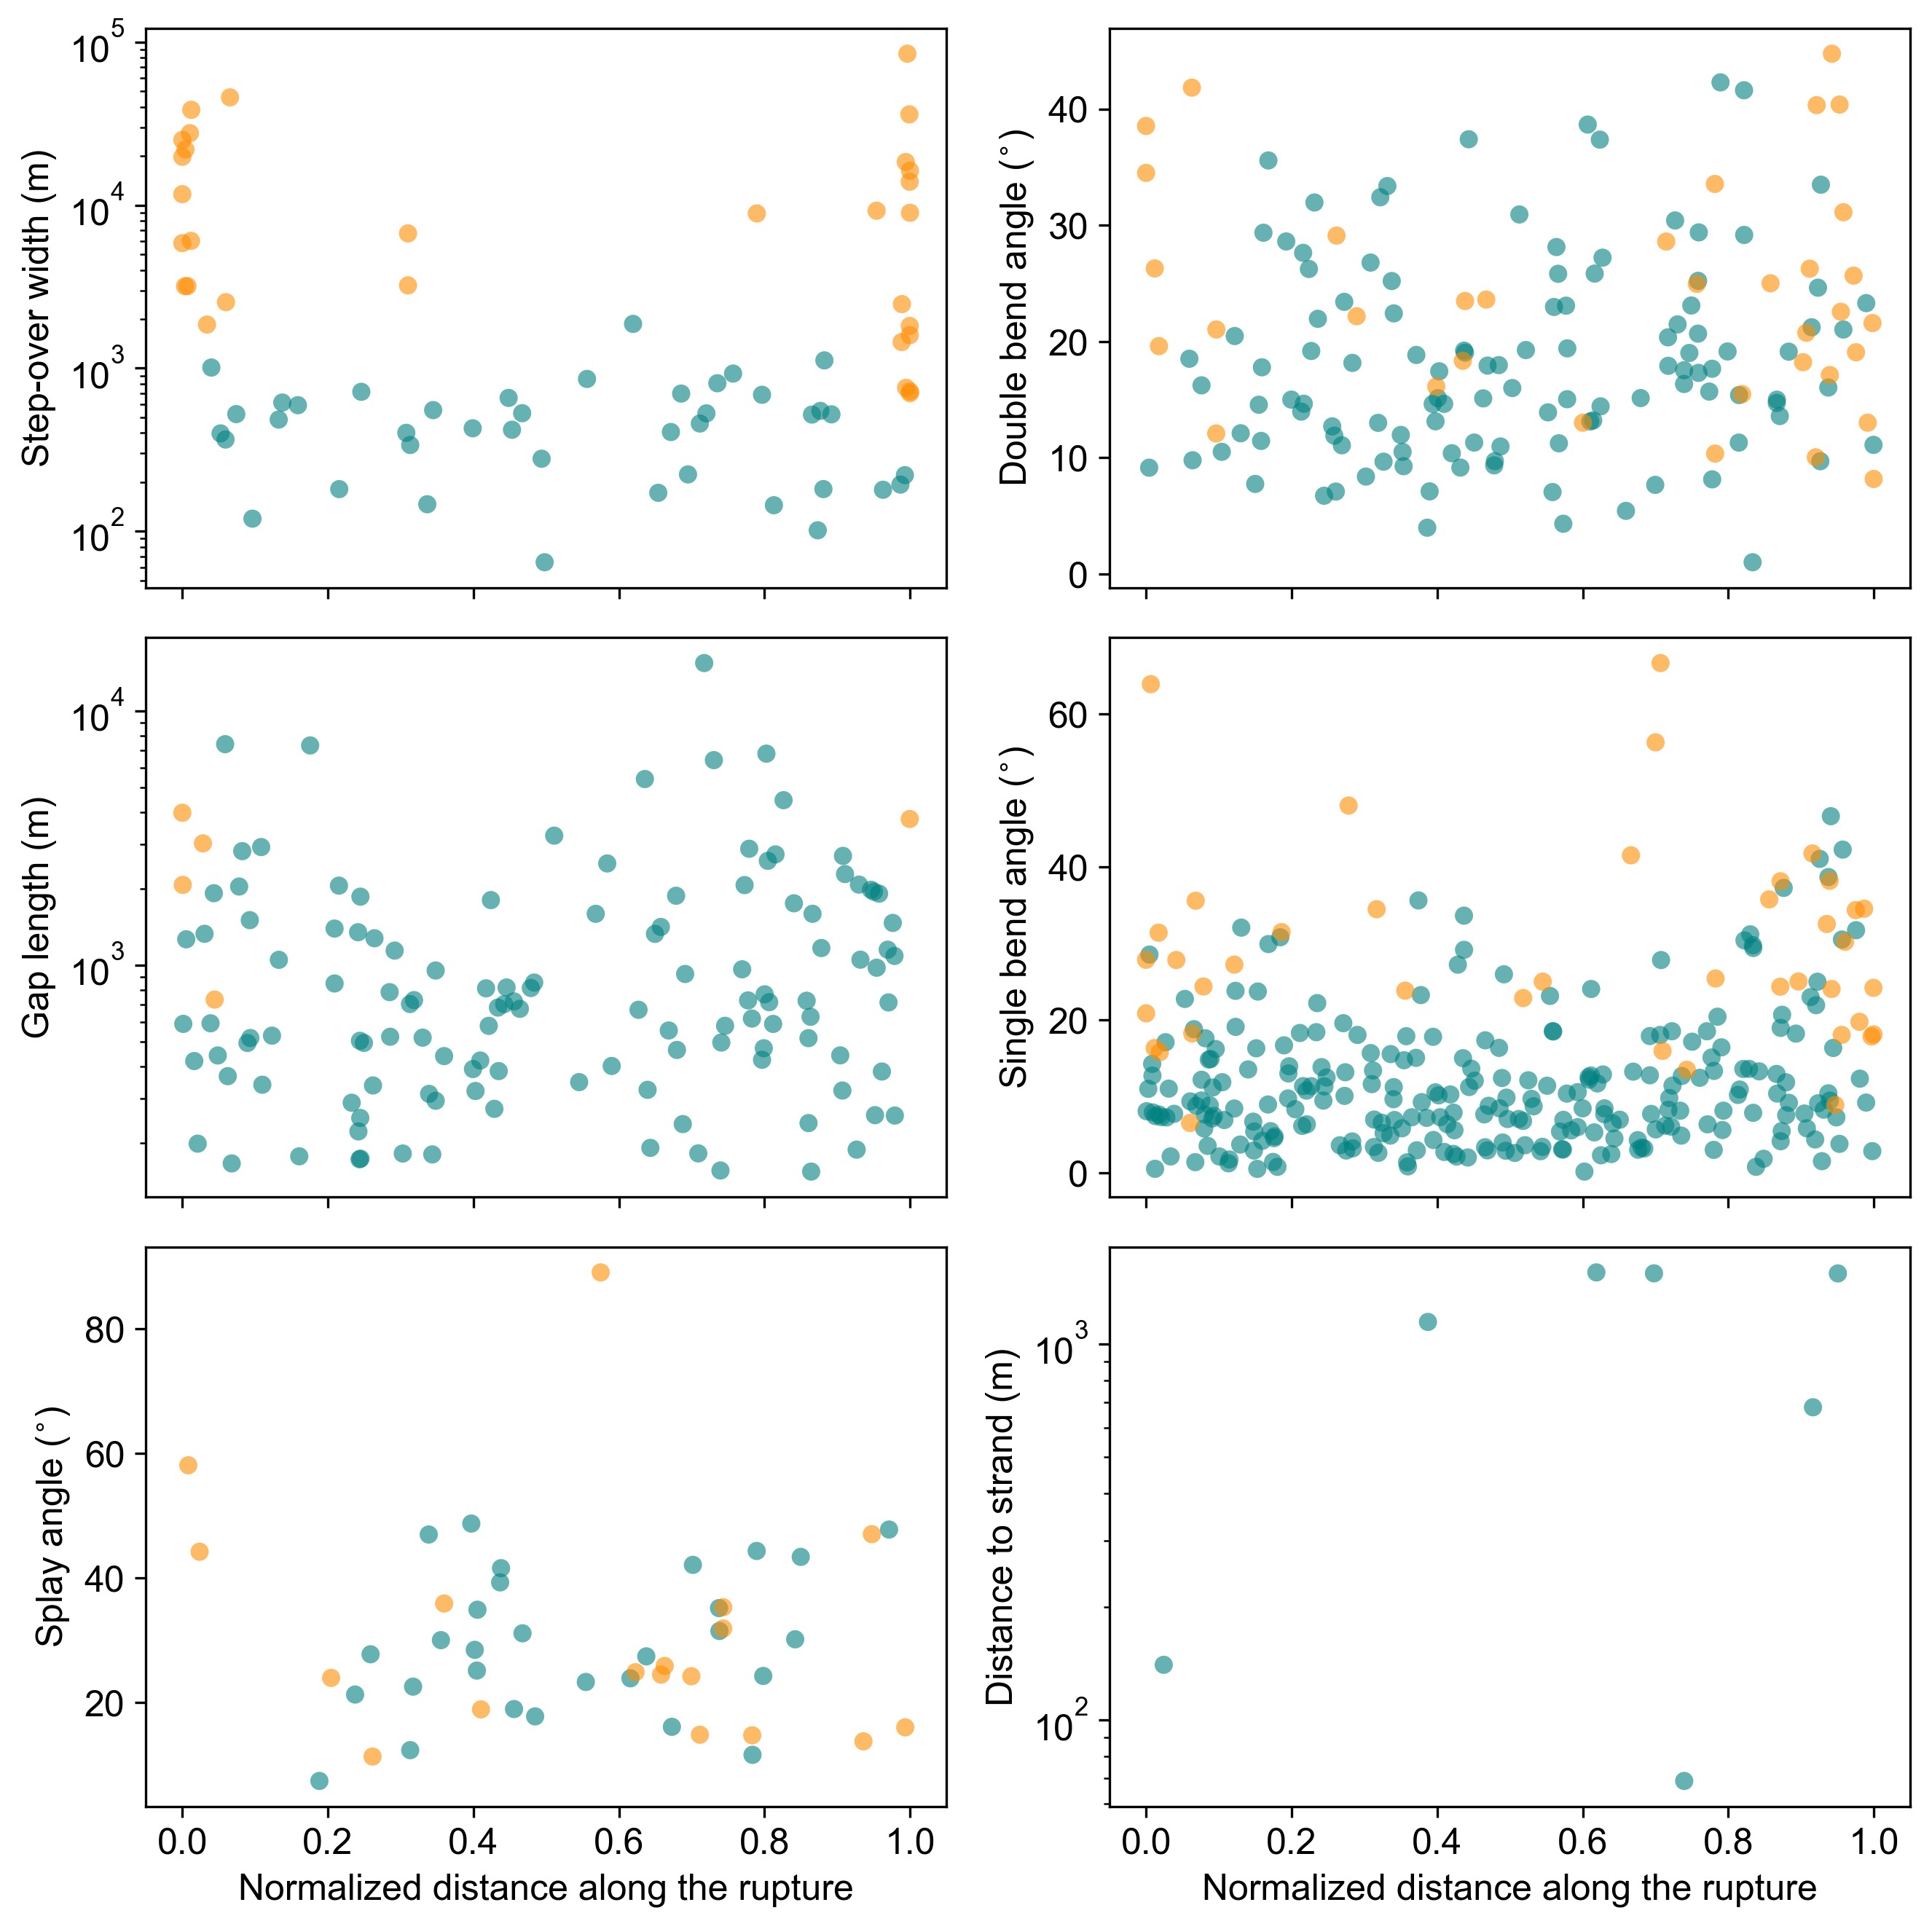

In [ ]:
fig, axes = plt.subplots(3,2,figsize=(9, 9),sharex=True,dpi=300)
palette = {'breached': 'teal', 'unbreached': 'darkorange'}
gate_distribution_along_strike(grouped,'stepover','none','length',axes[0,0],'Step-over width (m)',palette)
gate_distribution_along_strike(grouped,'bend','double','angle',axes[0,1],'Double bend angle ($^{\circ}$)',palette)
gate_distribution_along_strike(grouped,'bend','single','angle',axes[1,1],'Single bend angle ($^{\circ}$)',palette)
gate_distribution_along_strike(grouped,'gap','none','length',axes[1,0],'Gap length (m)',palette)
gate_distribution_along_strike(grouped,'splay','none','angle',axes[2,0],'Splay angle ($^{\circ}$)',palette)
gate_distribution_along_strike(grouped,'strand','none','length',axes[2,1],'Distance to strand (m)',palette)
plt.tight_layout()
plt.savefig('GRL/Normalized_dist_size.pdf')
plt.show()


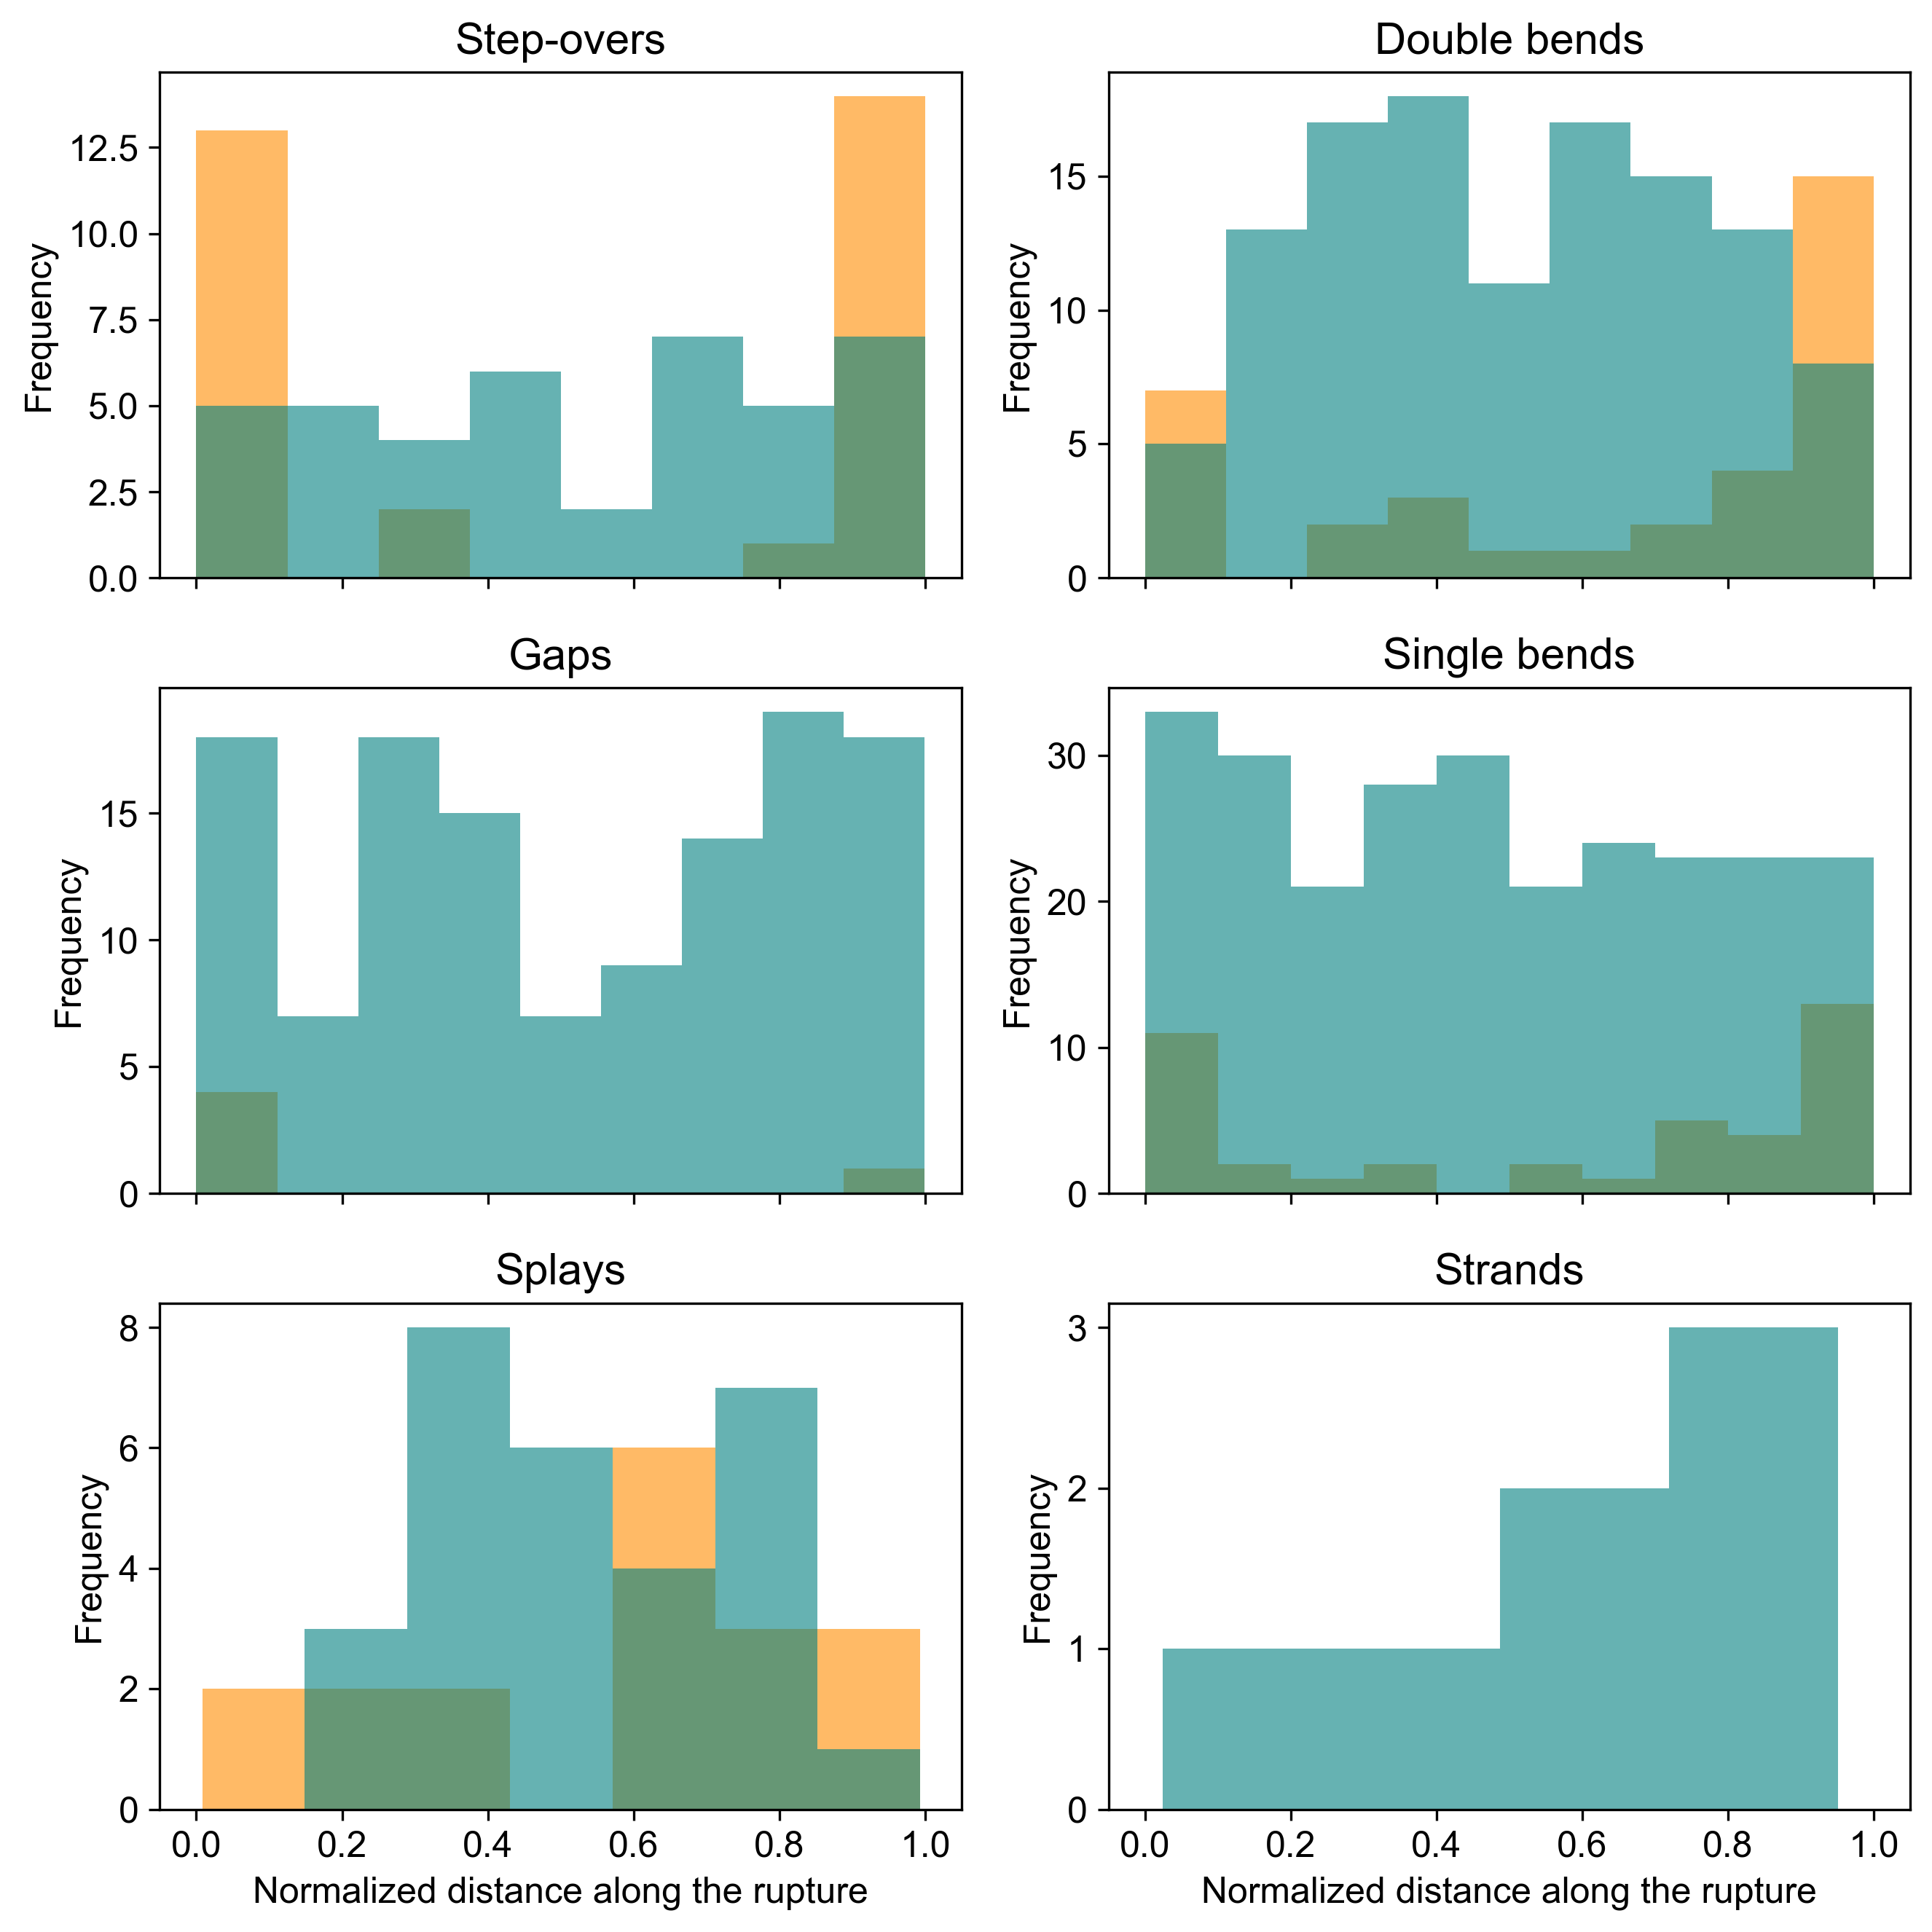

In [ ]:
fig, axes = plt.subplots(3,2,figsize=(9, 9),sharex=True,dpi=300)
palette = {'breached': 'teal', 'unbreached': 'darkorange'}
gate_distribution_along_strike_histogram(grouped,'stepover','none', axes[0,0],'Step-overs',palette)
gate_distribution_along_strike_histogram(grouped,'bend','double', axes[0,1],'Double bends',palette)
gate_distribution_along_strike_histogram(grouped,'bend','single', axes[1,1],'Single bends',palette)
gate_distribution_along_strike_histogram(grouped,'gap','none', axes[1,0],'Gaps',palette)
gate_distribution_along_strike_histogram(grouped,'splay','none', axes[2,0],'Splays',palette)
gate_distribution_along_strike_histogram(grouped,'strand','none', axes[2,1],'Strands',palette)
plt.tight_layout()
plt.savefig('GRL/Normalized_dist_size_histogram.pdf')
plt.show()

## Comparison to previous studies

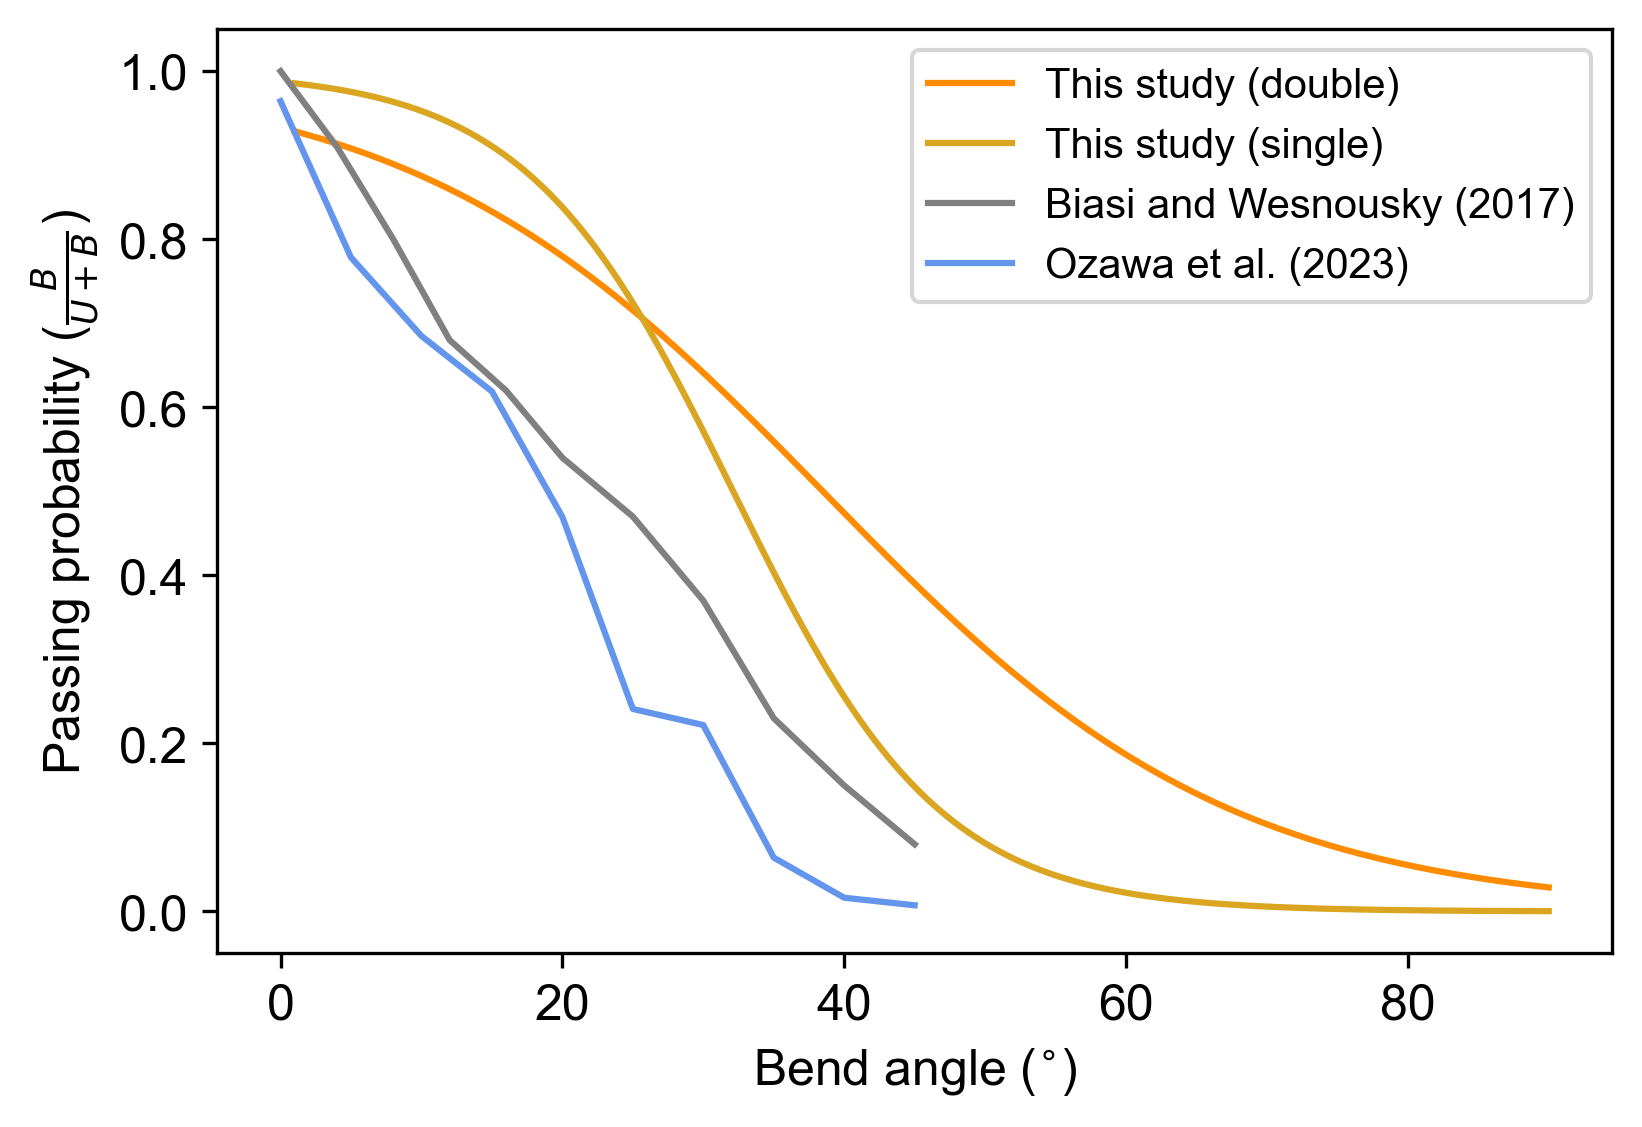

In [ ]:
group = grouped.get_group('bend')
selectB= group.groupby(group["Type (single or double)"])
double = selectB.get_group('double')
double['Bin'] = pd.cut(double['Length (m) or angle (deg)'], bins=np.linspace(0,90,10)) 
double['Bin Middle'] = double['Bin'].apply(lambda x: (x.left + x.right) / 2)

breached_counts = double[double['Breached or unbreached'] == 'breached'].groupby('Bin Middle').size()

unbreached_counts = double[double['Breached or unbreached'] == 'unbreached'].groupby('Bin Middle').size()

ratio = (breached_counts/(unbreached_counts+breached_counts))

unique_values = np.linspace(0,90,10)
unique_values = calculate_center(unique_values)

plt.figure(figsize=(6,4),dpi=300)
#plt.plot(unique_values,ratio,c='darkorange',label='This study (double)')
x = np.atleast_2d(np.linspace(1, 90, 1000)).T
proba_double = log_bend_double.predict_proba(x)[:,0]
proba_single = log_bend_single.predict_proba(x)[:,0]

plt.plot(x,proba_double,c='darkorange',label='This study (double)')
plt.plot(x,proba_single,c='goldenrod',label='This study (single)')
group = grouped.get_group('bend')
selectB= group.groupby(group["Type (single or double)"])
single = selectB.get_group('single')
single['Bin'] = pd.cut(single['Length (m) or angle (deg)'], bins=np.linspace(0,90,10)) 
single['Bin Middle'] = single['Bin'].apply(lambda x: (x.left + x.right) / 2)

breached_counts = single[single['Breached or unbreached'] == 'breached'].groupby('Bin Middle').size()

unbreached_counts = single[single['Breached or unbreached'] == 'unbreached'].groupby('Bin Middle').size()

ratio = (breached_counts/(unbreached_counts+breached_counts))

unique_values = np.linspace(0,90,10)
unique_values = calculate_center(unique_values)
#plt.plot(unique_values,ratio,c='goldenrod',label='This study (single)')

# load data from Biasi and Wesnousky (2017) and Ozawa et al. (2023)
Bend_angle_Biasi = np.array([0, 4, 8, 12, 16, 20, 25, 30, 35, 40, 45])
PP_Biasi = np.array([1, 0.91, 0.80, 0.68, 0.62, 0.54, 0.47, 0.37, 0.23, 0.15, 0.08])

Bend_angle_Ozawa = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45])
PP_Ozawa = np.array([0.96428571, 0.77829376, 0.68489335, 0.61890165, 0.46959471, 0.24105128, 0.22185883, 0.06410775, 0.01640081, 0.00738151])

plt.plot(Bend_angle_Biasi, PP_Biasi,'gray',label='Biasi and Wesnousky (2017)')
plt.plot(Bend_angle_Ozawa,PP_Ozawa,'cornflowerblue', label='Ozawa et al. (2023)')
plt.ylabel(r'Passing probability ($\frac{B}{U+B}$)',fontsize=12)
plt.xlabel(r'Bend angle ($^{\circ}$)',fontsize=12)
plt.legend(fontsize=10)
plt.savefig('GRL/bendPPcomparisons.pdf')

# Displacement distributions near earthquake gates

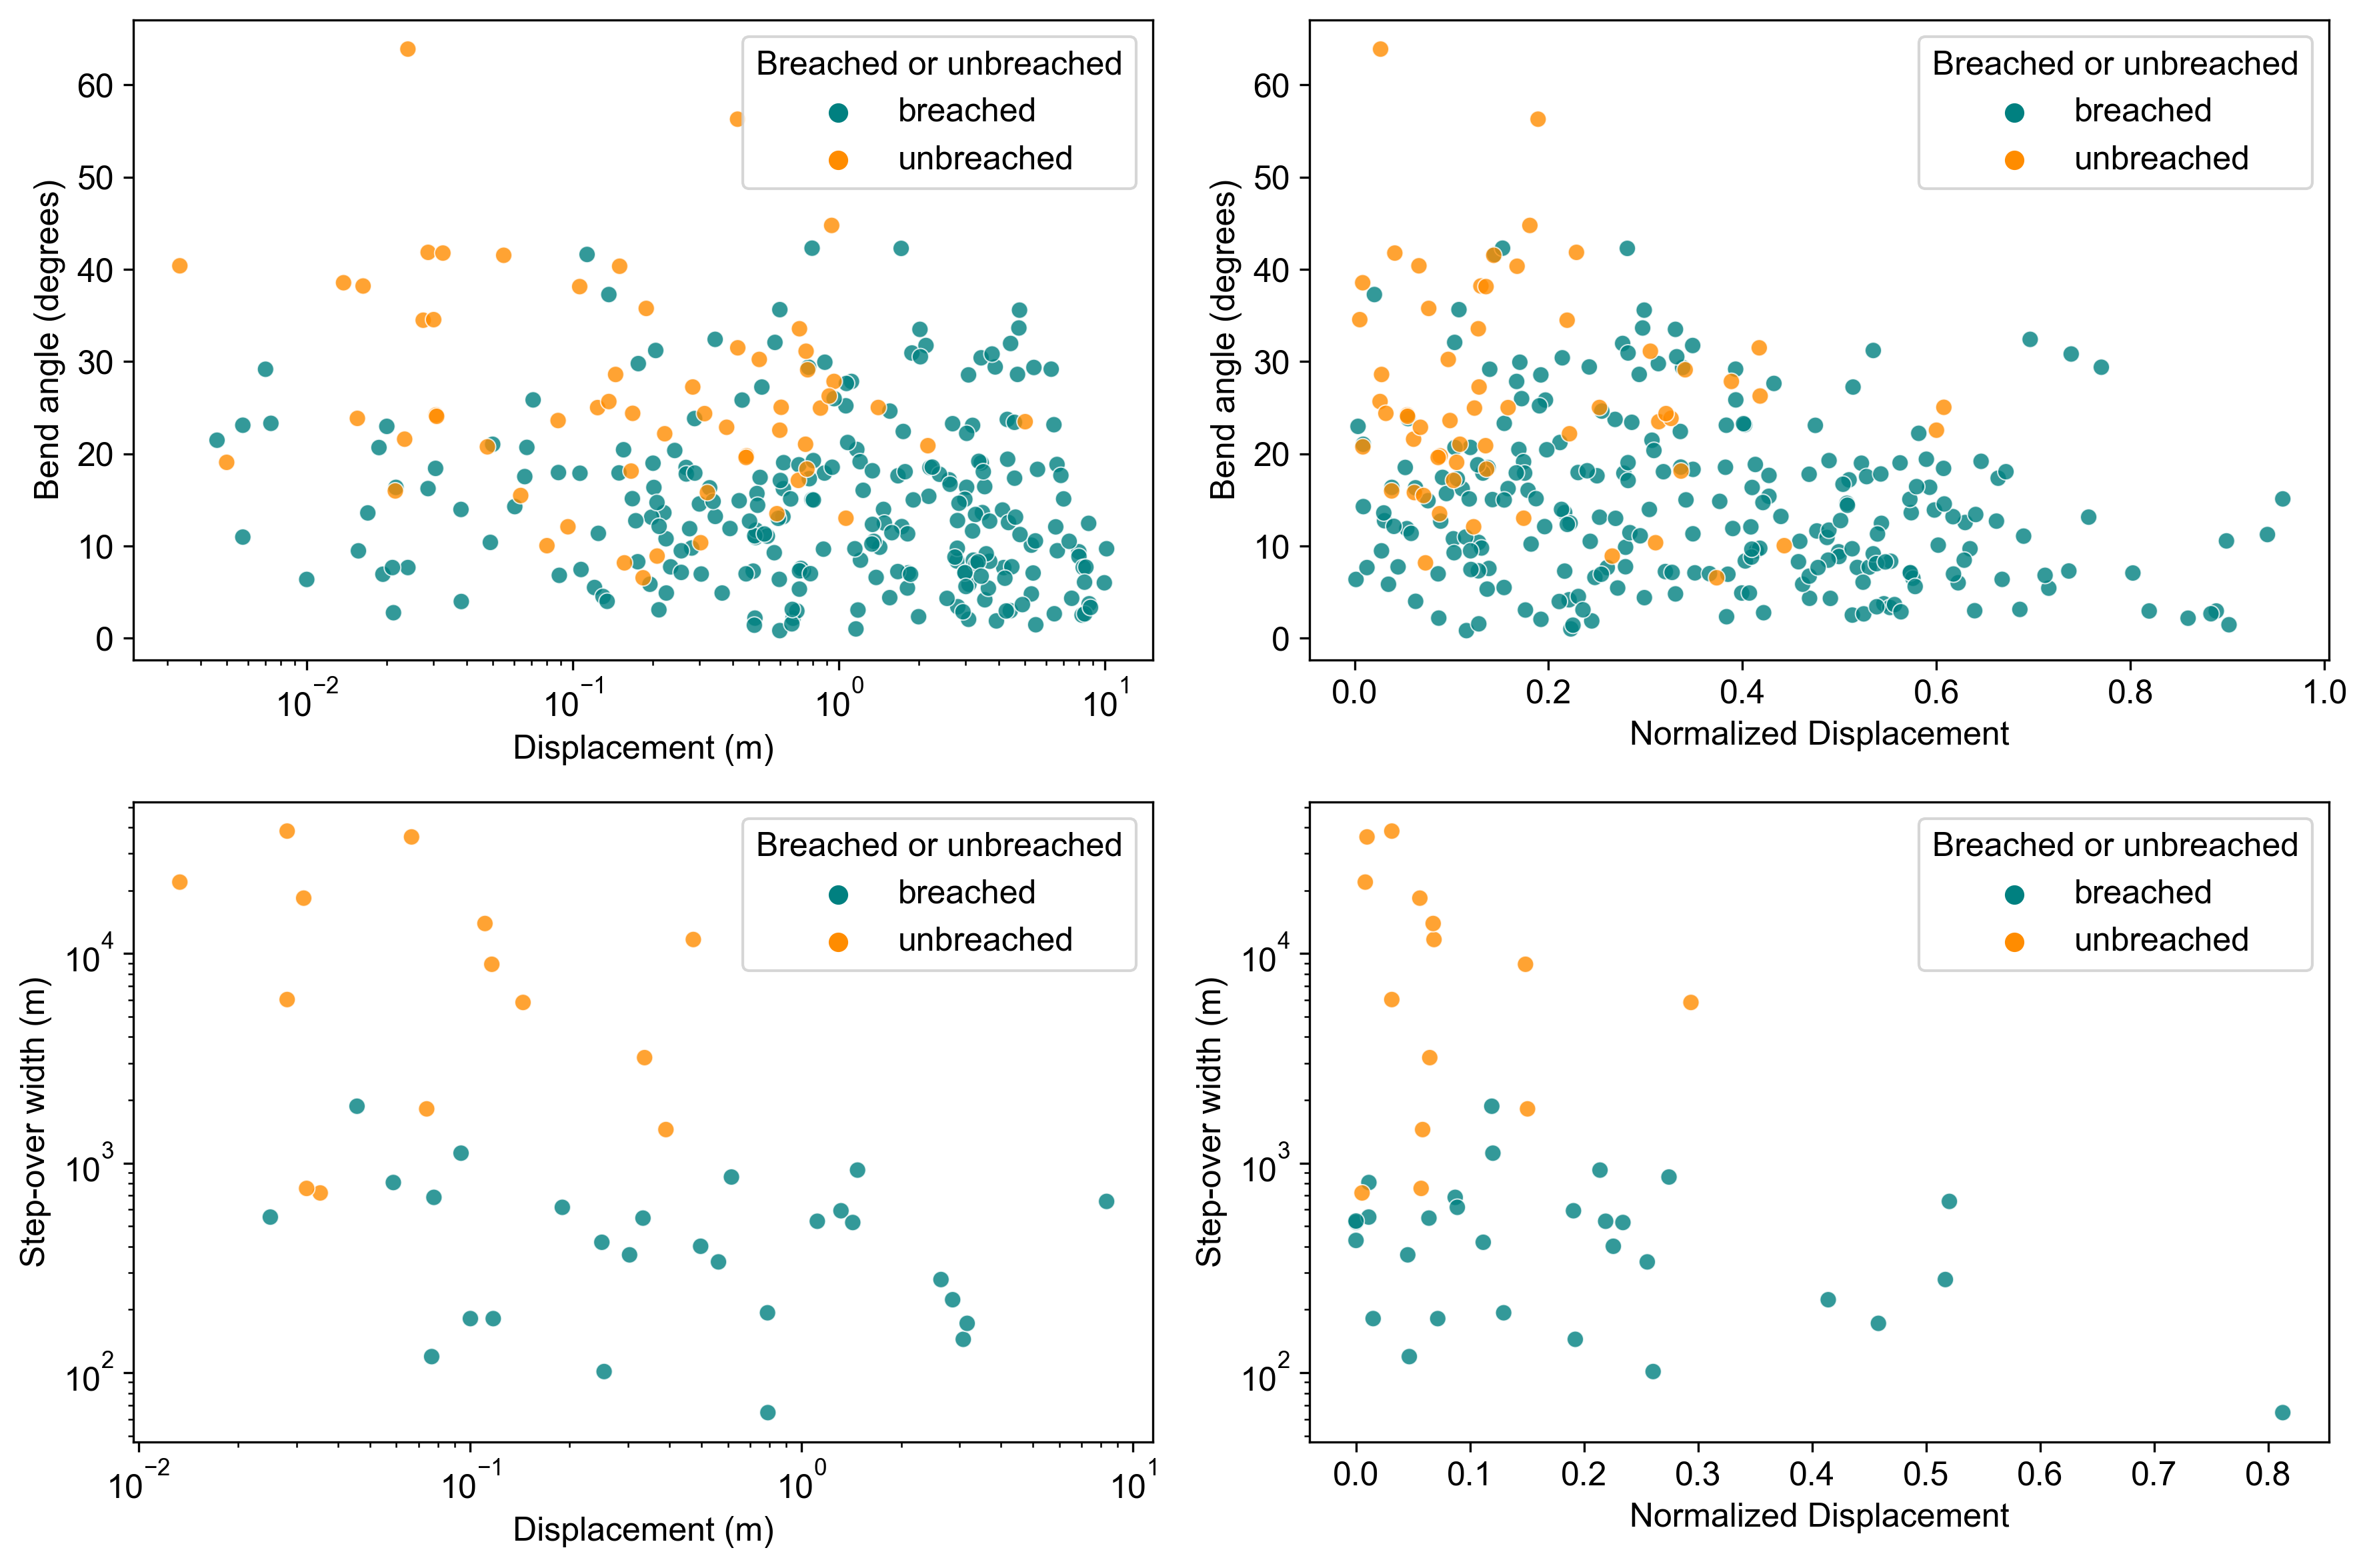

In [ ]:
bends = grouped.get_group('bend')
stepovers = grouped.get_group('stepover')

custom_palette = {"breached": "teal", "unbreached": "darkorange"}

fig, axes = plt.subplots(2,2,figsize=(12,8),dpi=300)
sns.scatterplot(data=bends, y='Length (m) or angle (deg)', x='Slip at gate (m)', hue='Breached or unbreached', alpha=0.8, palette=custom_palette,ax=axes[0,0])
axes[0,0].set_ylabel('Bend angle (degrees)')
axes[0,0].set_xlabel('Displacement (m)')
axes[0,0].set_xscale('log')
# axes[0].set_ylim(0,1)

sns.scatterplot(data=stepovers, y='Length (m) or angle (deg)', x='Slip at gate (m)', hue='Breached or unbreached', alpha=0.8, palette=custom_palette,ax=axes[1,0])
axes[1,0].set_ylabel('Step-over width (m)')
axes[1,0].set_yscale('log')
axes[1,0].set_xlabel('Displacement (m)')
# axes[1].set_ylim(0,1)

sns.scatterplot(data=bends, y='Length (m) or angle (deg)', x='Normalized slip at gate', hue='Breached or unbreached', alpha=0.8, palette=custom_palette,ax=axes[0,1])
axes[0,1].set_ylabel('Bend angle (degrees)')
axes[0,1].set_xlabel('Normalized Displacement')
axes[1,0].set_xscale('log')
# axes[0].set_ylim(0,1)

sns.scatterplot(data=stepovers, y='Length (m) or angle (deg)', x='Normalized slip at gate', hue='Breached or unbreached', alpha=0.8, palette=custom_palette,ax=axes[1,1])
axes[1,1].set_ylabel('Step-over width (m)')
axes[1,1].set_yscale('log')
axes[1,1].set_xlabel('Normalized Displacement')

plt.tight_layout()
plt.savefig('GRL/normalized_slip_at_gate.pdf')

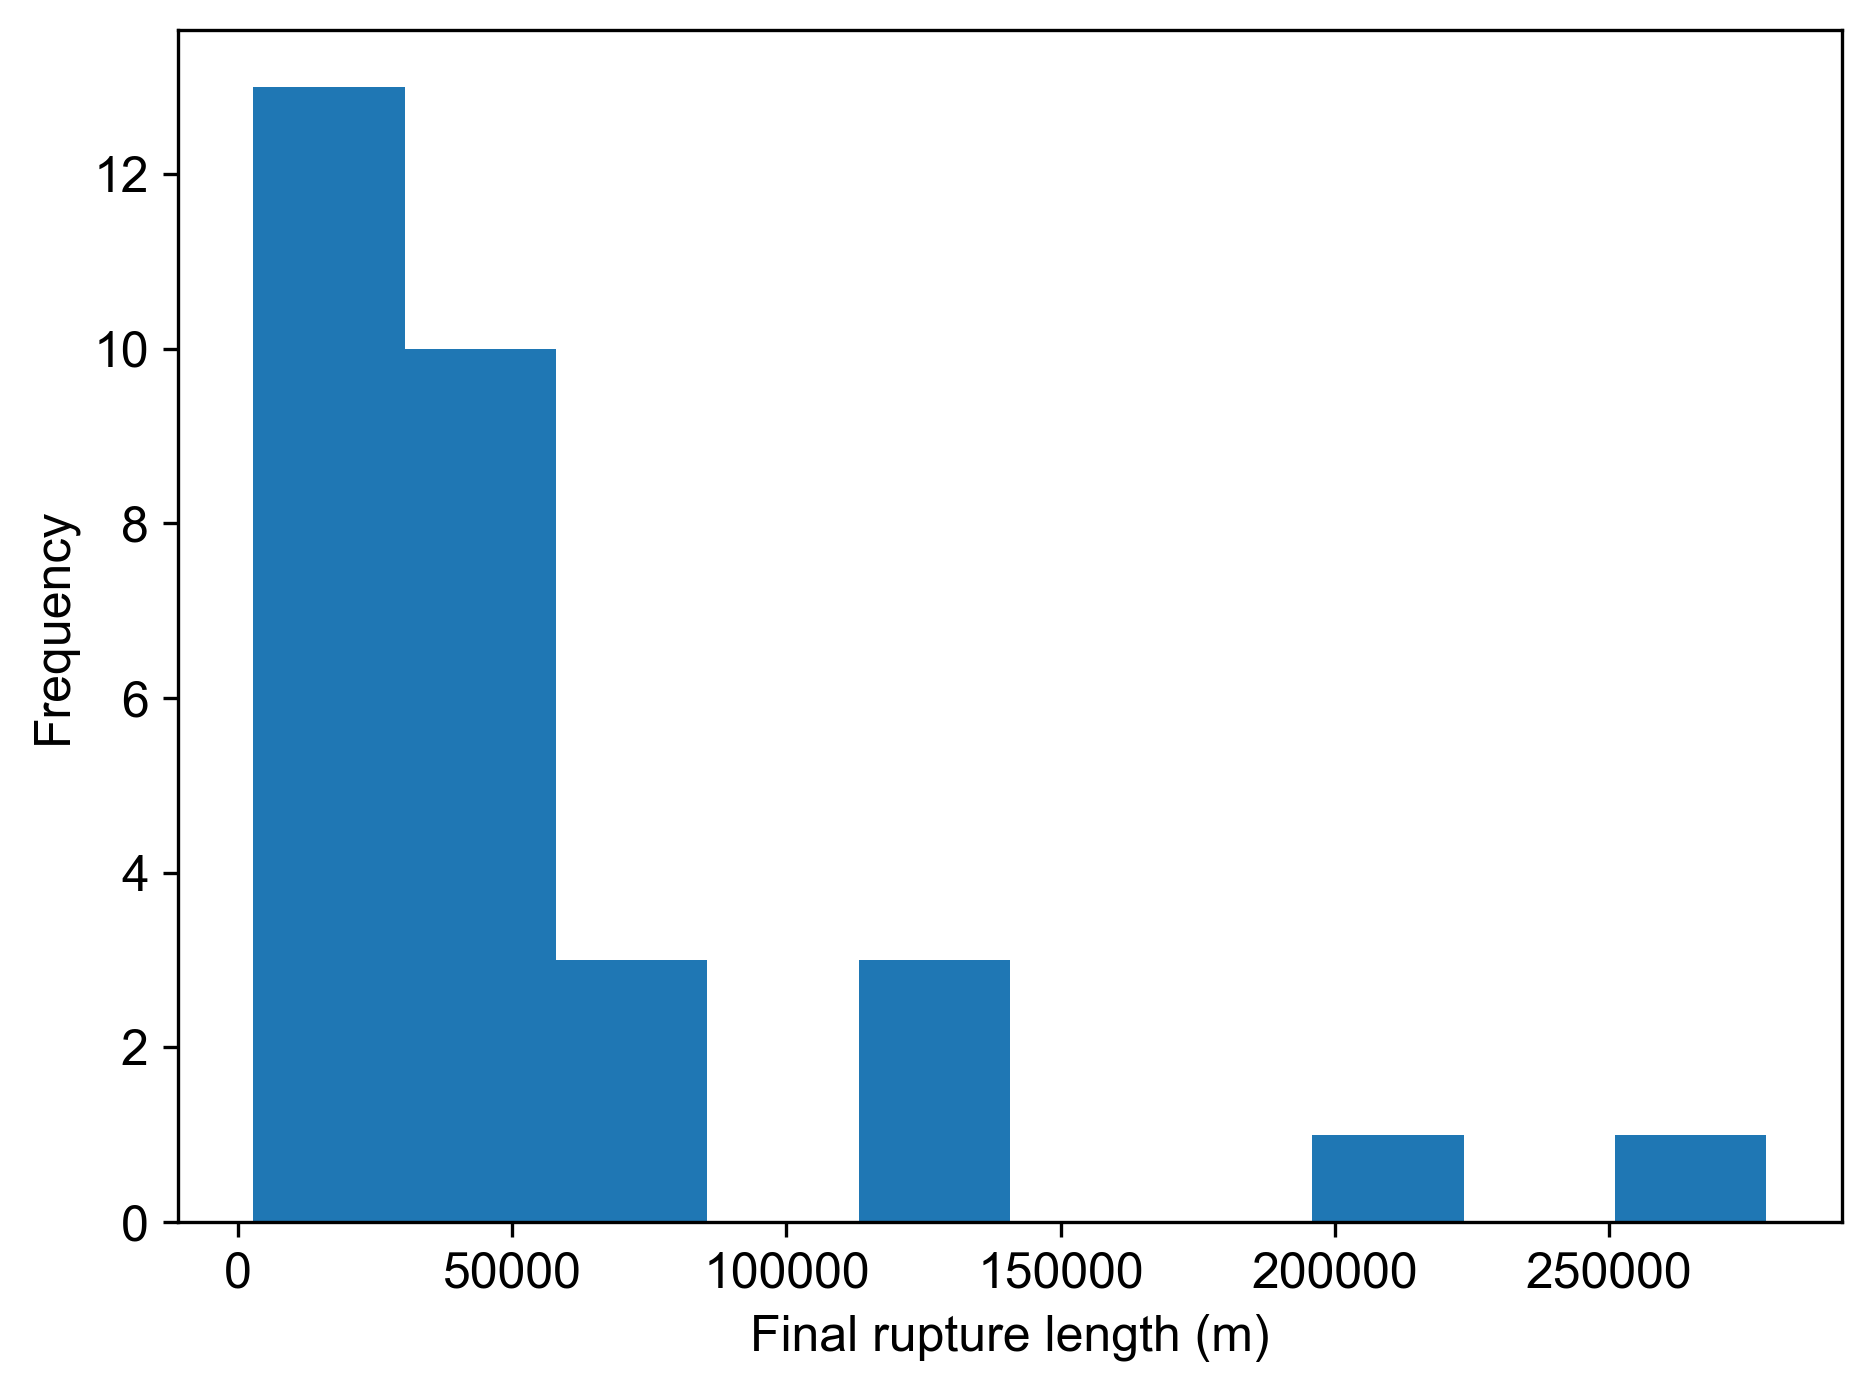

In [ ]:
SRL = lastpt # final rupture length of events
plt.figure(dpi=300)
plt.hist(SRL)
plt.ylabel('Frequency')
plt.xlabel('Final rupture length (m)')
plt.tight_layout()

### Event size vs earthquake gate size

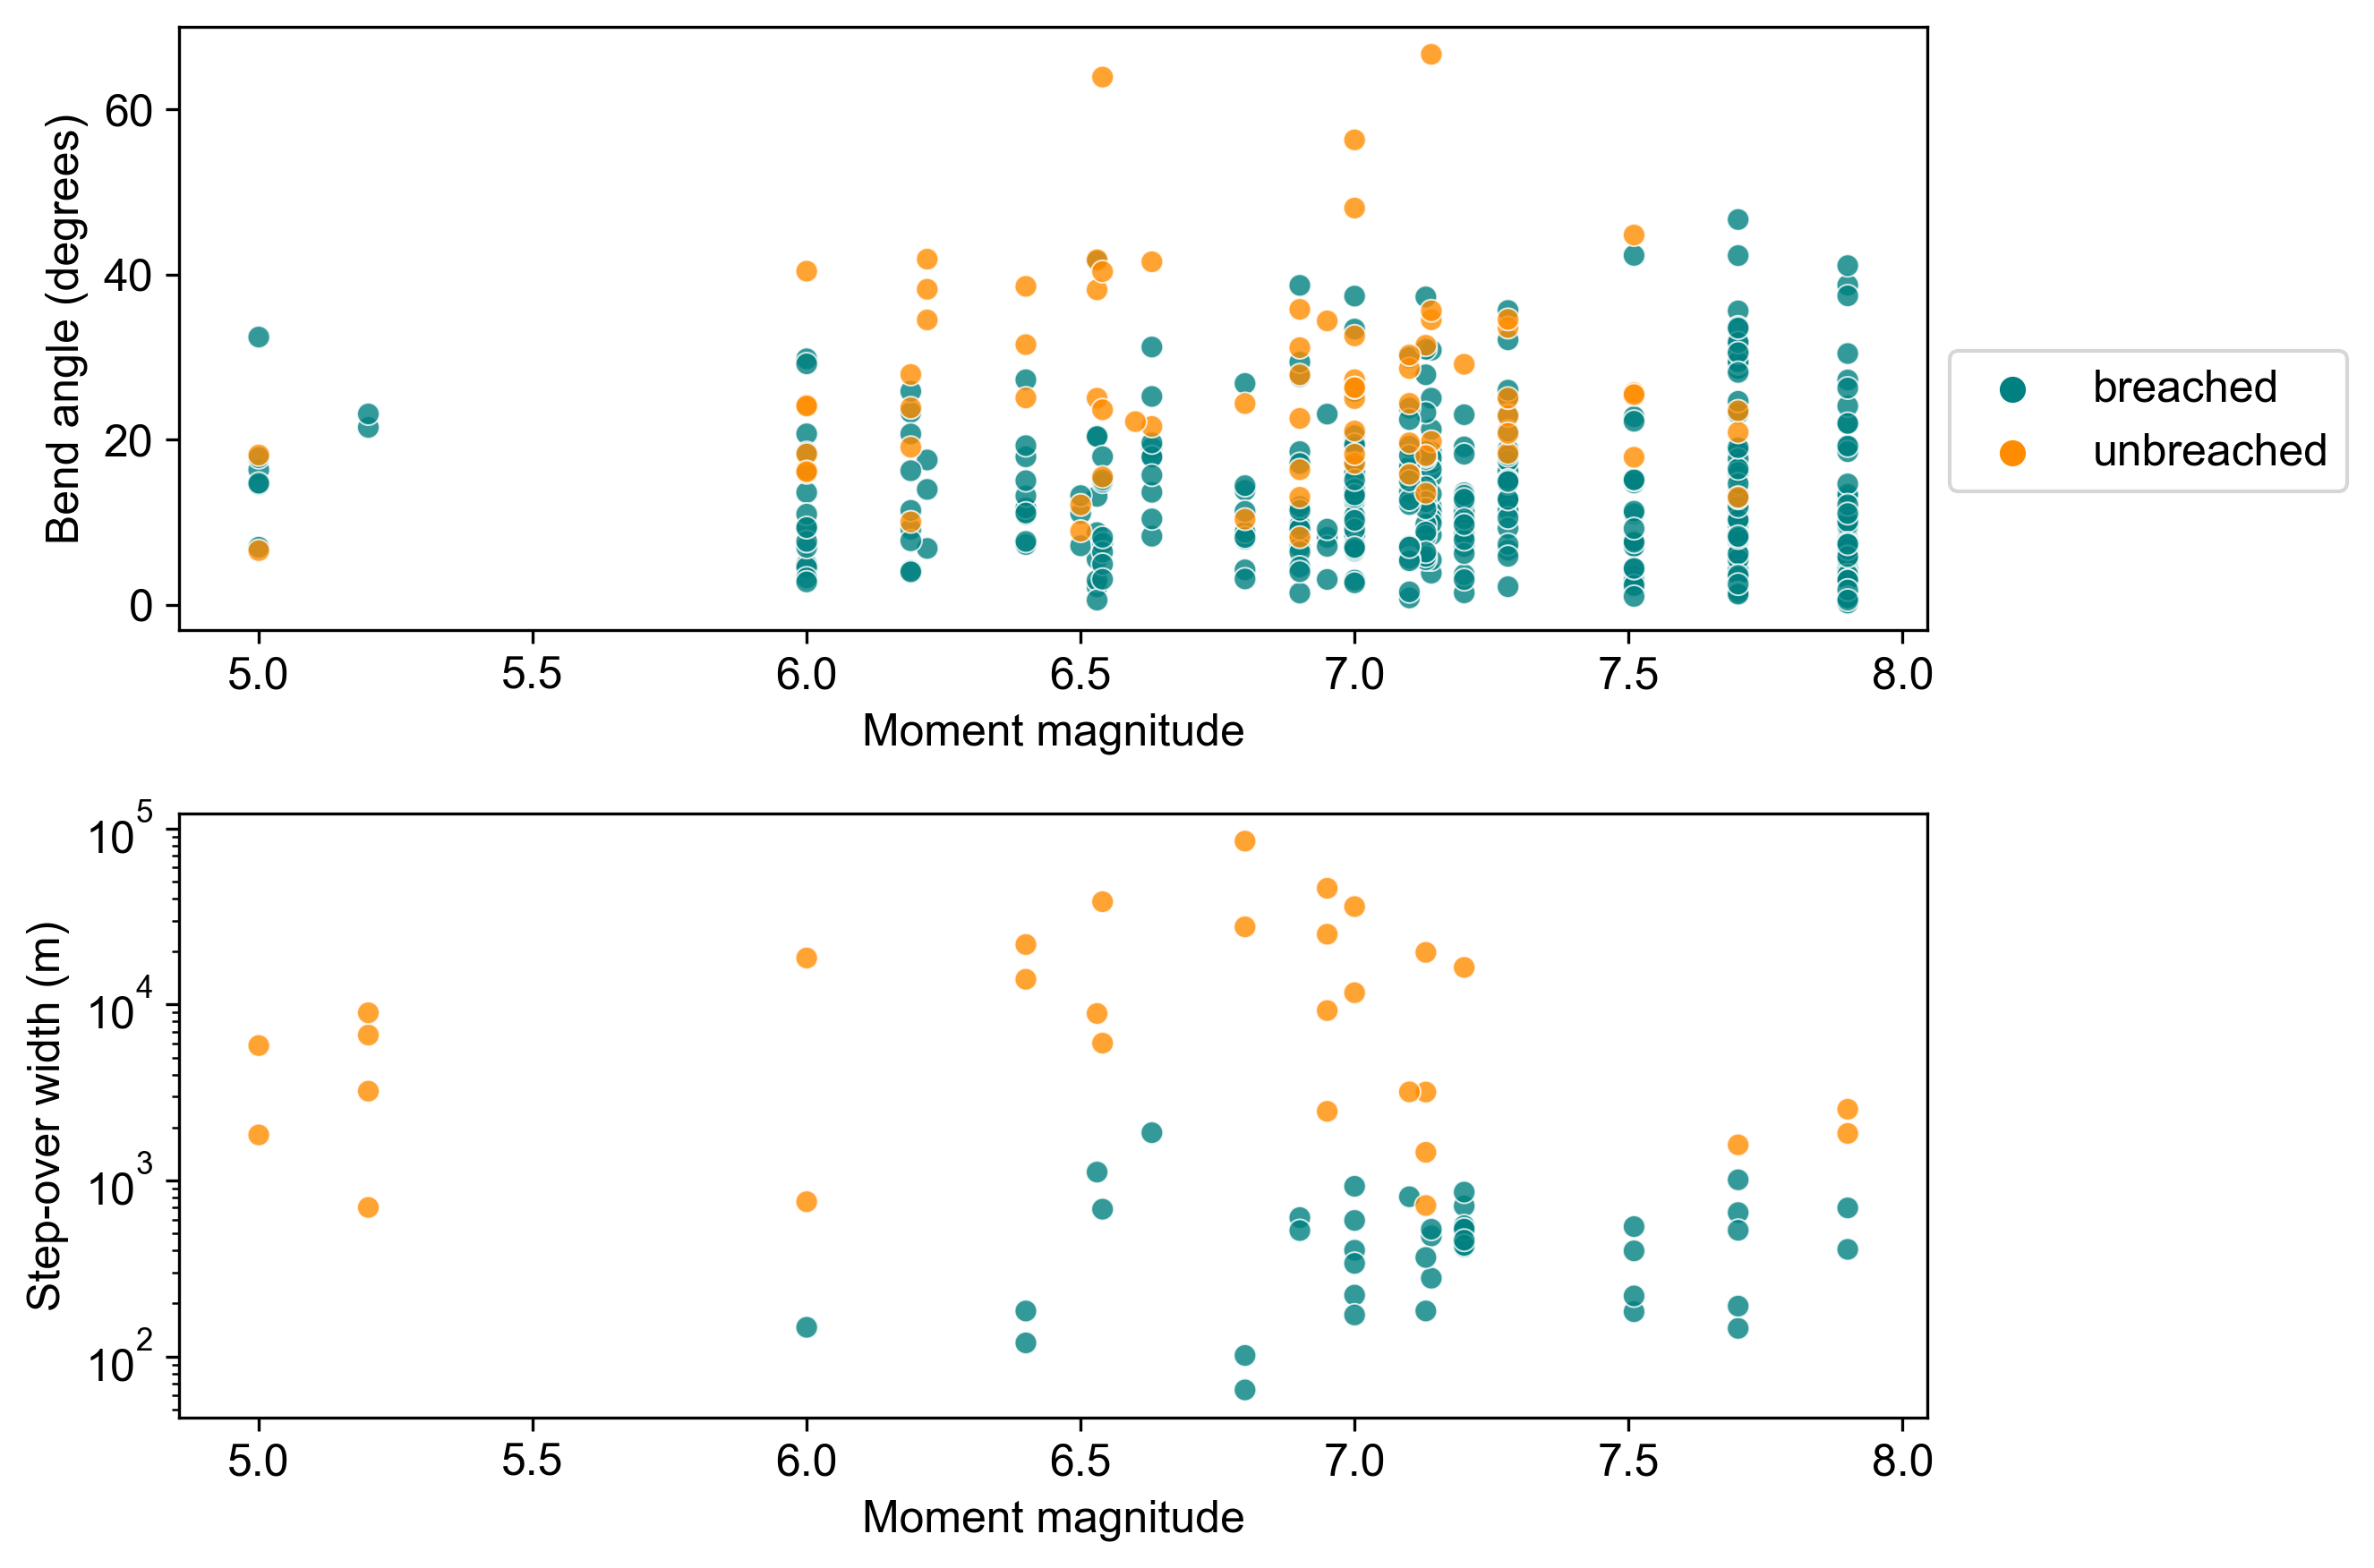

In [ ]:
bends = grouped.get_group('bend')
stepovers = grouped.get_group('stepover')

custom_palette = {"breached": "teal", "unbreached": "darkorange"}

fig, axes = plt.subplots(2,1,figsize=(9,6),dpi=300)
sns.scatterplot(data=bends, x='Magnitude', y='Length (m) or angle (deg)', hue='Breached or unbreached', alpha=0.8, palette=custom_palette,ax=axes[0])
axes[0].set_ylabel('Bend angle (degrees)')
axes[0].set_xlabel('Moment magnitude')
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 0.5))

sns.scatterplot(data=stepovers,  x='Magnitude', y='Length (m) or angle (deg)', hue='Breached or unbreached', alpha=0.8, palette=custom_palette,ax=axes[1])
axes[1].set_xlabel('Moment magnitude')
axes[1].set_ylabel('Step-over width (m)')
axes[1].set_yscale('log')
axes[1].legend().remove()

plt.tight_layout()
plt.savefig('GRL/size_vs_mag.pdf')

### Earthquake gate size vs distance to epicenter

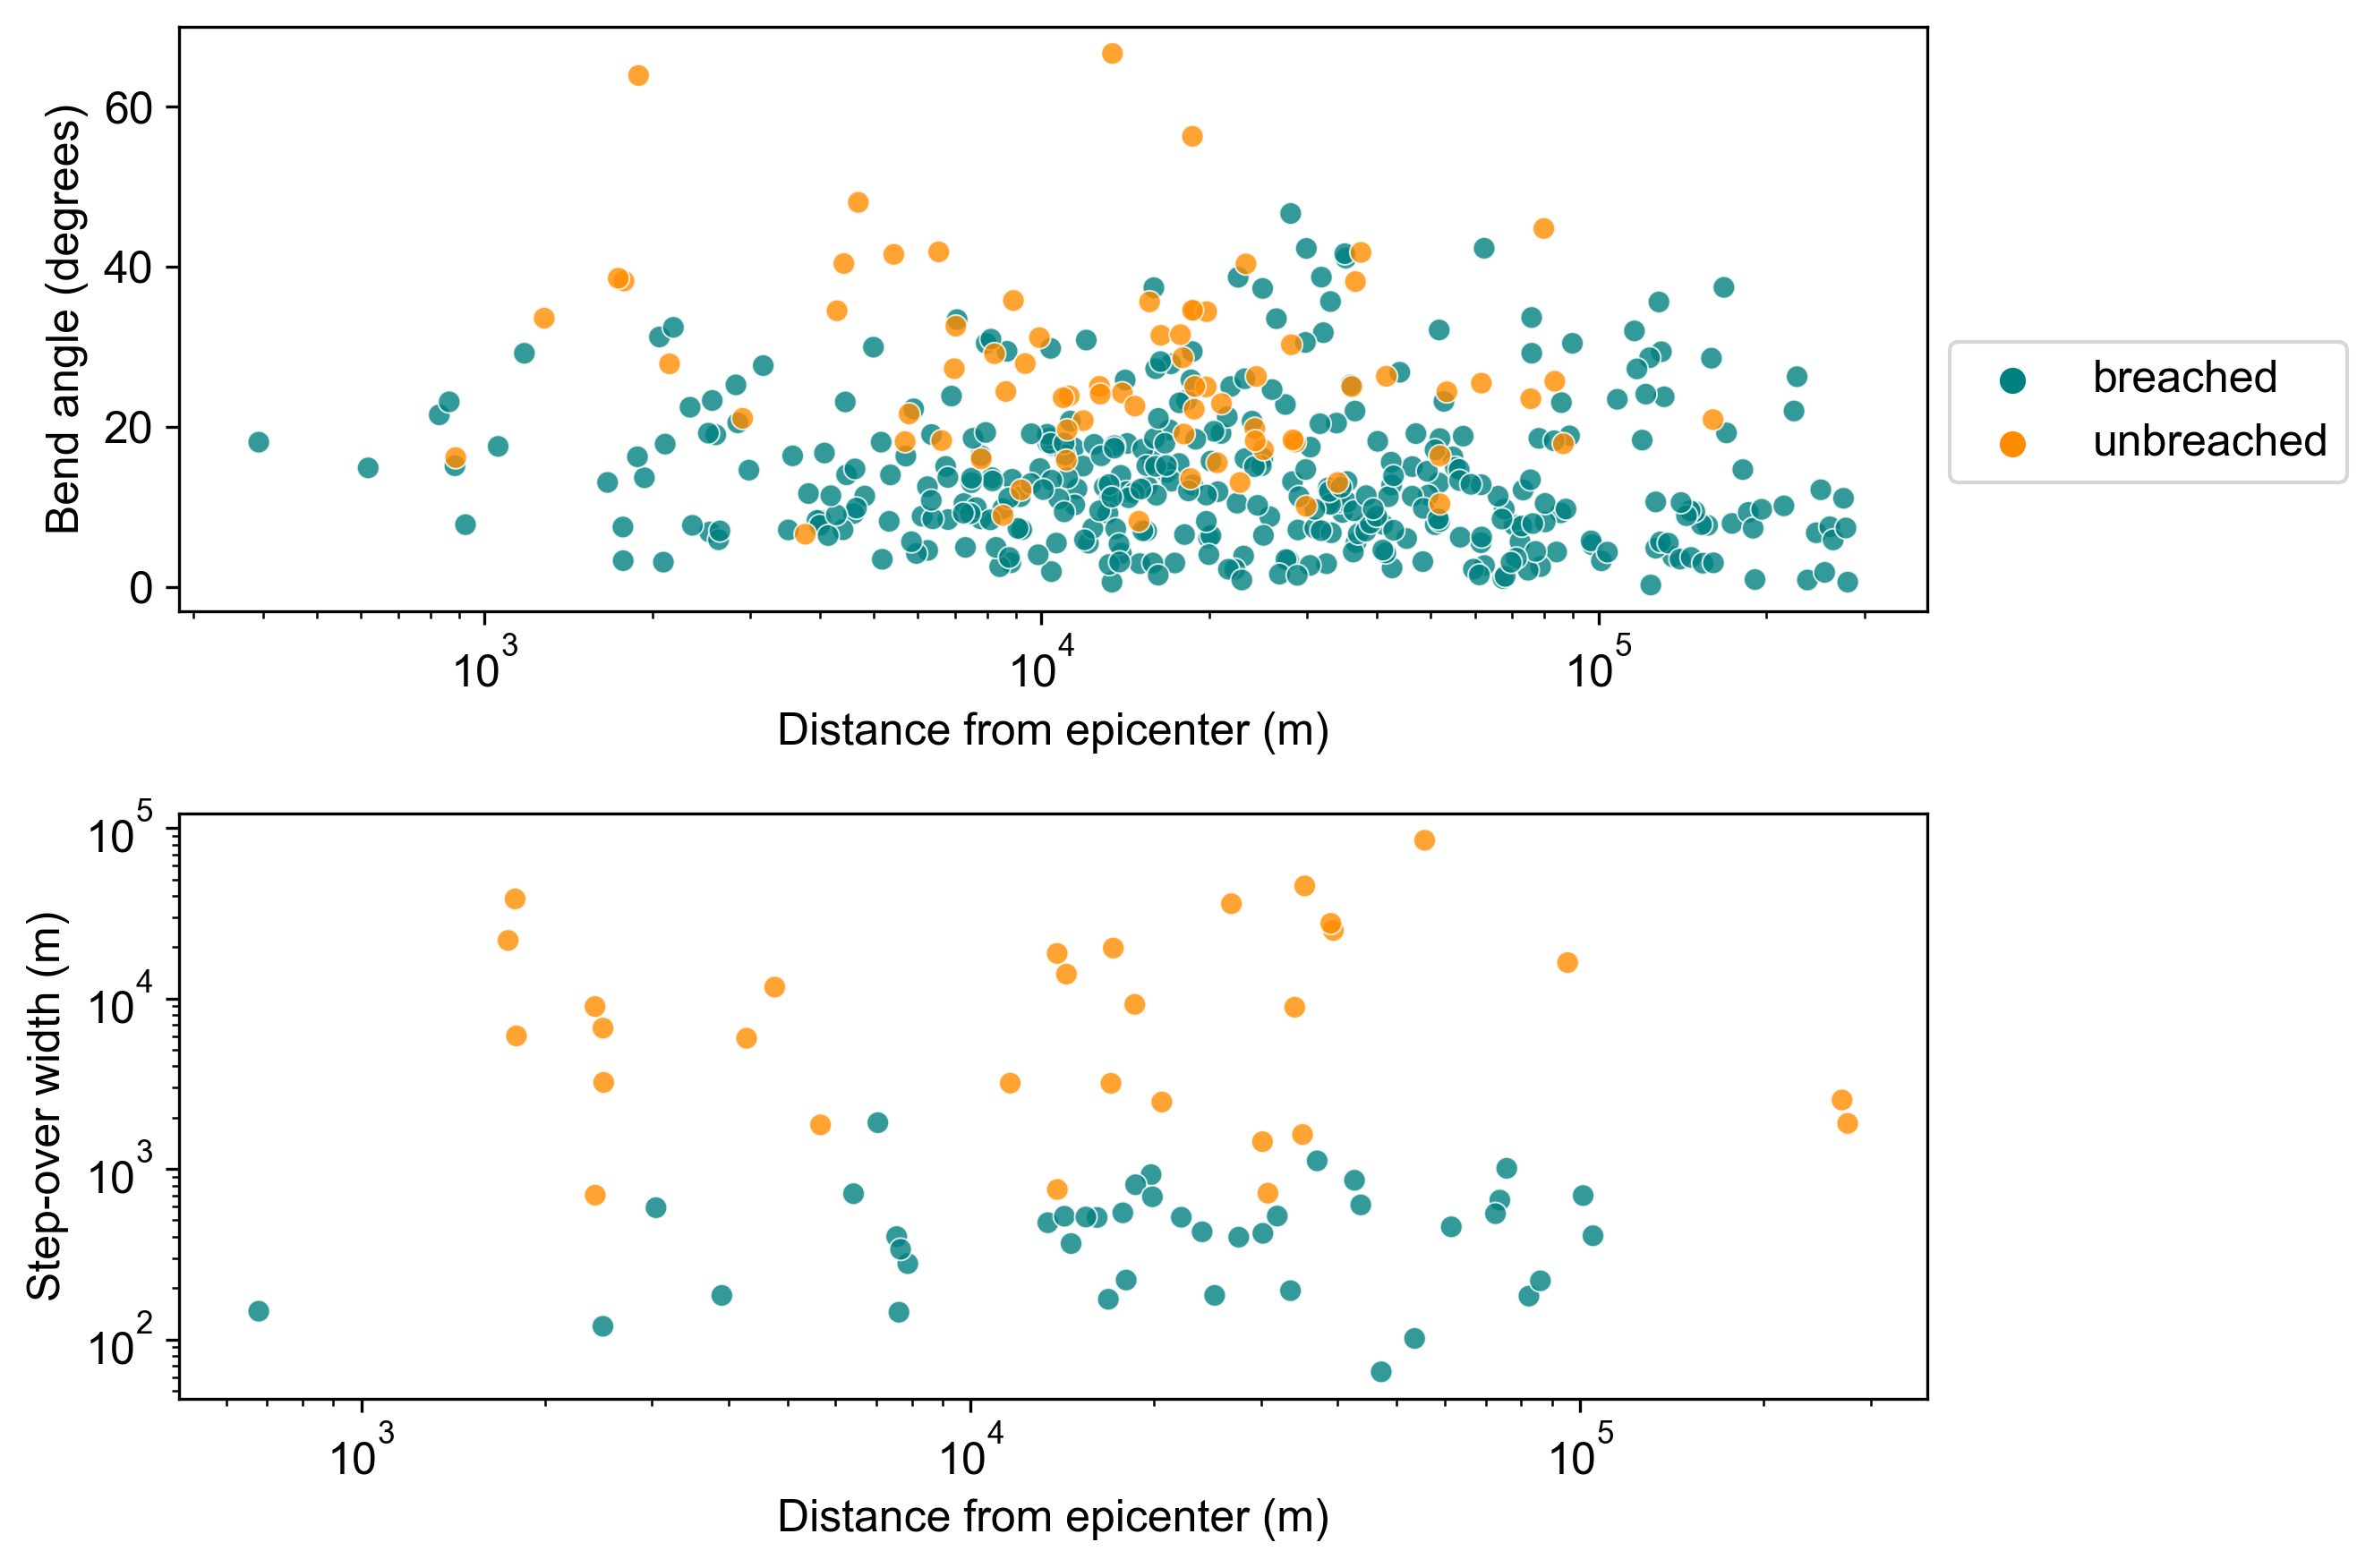

In [ ]:
bends = grouped.get_group('bend')
stepovers = grouped.get_group('stepover')

custom_palette = {"breached": "teal", "unbreached": "darkorange"}

fig, axes = plt.subplots(2,1,figsize=(9,6),dpi=300)
sns.scatterplot(data=bends, x='Distance to epicenter', y='Length (m) or angle (deg)', hue='Breached or unbreached', alpha=0.8, palette=custom_palette,ax=axes[0])
axes[0].set_ylabel('Bend angle (degrees)')
axes[0].set_xlabel('Distance from epicenter (m)')
axes[0].set_xscale('log')
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 0.5))

sns.scatterplot(data=stepovers,  x='Distance to epicenter', y='Length (m) or angle (deg)', hue='Breached or unbreached', alpha=0.8, palette=custom_palette,ax=axes[1])
axes[1].set_xlabel('Distance from epicenter (m)')
axes[1].set_ylabel('Step-over width (m)')
axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].legend().remove()

plt.tight_layout()
plt.savefig('GRL/size_vs_epi.pdf')

### Making a latex table and exporting all the results

In [ ]:
# probabilities (50% mark)
x_double = np.atleast_2d(38).T
proba_double = log_bend_double.predict_proba(x_double)[:,0]
x_single = np.atleast_2d(32).T
proba_single = log_bend_single.predict_proba(x_single)[:,0]
x_stepover = np.atleast_2d(np.log10(1170)).T
proba_stepover = log_stepover.predict_proba(x_stepover)[:,0]
x_gap = np.atleast_2d(np.log10(24500)).T
proba_gap= log_gap.predict_proba(x_gap)[:,0]

In [ ]:
stepover = grouped.get_group('stepover')
restraining_stepover = stepover[stepover["Type (releasing or restraining)"] == 'restraining']
releasing_stepover = stepover[stepover["Type (releasing or restraining)"] == 'releasing']

bend = grouped.get_group('bend')
double_bend = bend[bend["Type (single or double)"] == 'double']
single_bend = bend[bend["Type (single or double)"] == 'single']
restraining_bend = double_bend[double_bend["Type (releasing or restraining)"] == 'restraining']
releasing_bend = double_bend[double_bend["Type (releasing or restraining)"] == 'releasing']

gap = grouped.get_group('gap')
splay = grouped.get_group('splay')
strand = grouped.get_group('strand')

n_stepovers = len(stepover)
n_releasing_stepovers = len(releasing_stepover)
n_restraining_stepovers = len(restraining_stepover)
n_bends = len(bend)
n_single_bends = len(single_bend)
n_double_bends = len(double_bend)
n_releasing_double_bends = len(releasing_bend)
n_restraining_double_bends = len(restraining_bend)
n_gaps = len(gap)
n_splays = len(splay)
n_strands = len(strand)

In [ ]:
# info to export 

# number of features of each type 
data_mapped = {
    'Feature': ['Step-overs', 'Releasing step-overs', 'Restraining step-overs', 'Bends', 'Single bends', 'Double bends', 'Releasing double bends', 'Restraining double bends', 'Gaps','Splays','Strands'],
    'Number mapped': [n_stepovers, n_releasing_stepovers, n_restraining_stepovers, n_bends, n_single_bends, n_double_bends, n_releasing_double_bends, n_restraining_double_bends, n_gaps, n_splays, n_strands]
}

mapped_data_export = pd.DataFrame(data_mapped)

latex_table_mapped = mapped_data_export.to_latex(index=False) 
with open('latex_table_mapped.tex', 'w') as file:
    file.write(latex_table_mapped)


# ks test for populations of earthquake gates

data_ks = {
    'Feature A': ['Breached double bend', 'Breached single bend', 'Breached step-over', 'Breached gaps', 'Breached splay', 'Releasing unbreached bend', 'Releasing breached bend', 'Releasing breached step-over', 'Releasing unbreached step-over'],
    'Feature B': ['Unbreached double bend', 'Unbreached single bend', 'Unbreached step-over', 'Unbreached gaps', 'Unbreached splay', 'Restraining unbreached bend', 'Restraining breached bend', 'Restraining breached step-over', 'Restraining unbreached step-over'],
    'p-value from ks test': [double_bend_ks[1], single_bend_ks[1], stepover_ks[1], gap_ks[1], splay_ks[1], releasing_restraining_unbreached_bend_ks[1], releasing_restraining_breached_bend_ks[1], releasing_restraining_breached_stepover_ks[1], releasing_restraining_unbreached_stepover_ks[1]]
}

ks_data_export = pd.DataFrame(data_ks)

latex_table_ks = ks_data_export.to_latex(index=False) 
with open('latex_table_ks.tex', 'w') as file:
    file.write(latex_table_ks)

# passing probabilities 

data_passing_probabilities = {
    'Feature': ['Double bends', 'Single bends', 'Step-overs', 'Gaps'],
    'Closest geometry to passing probability = 50%': [int(x_double[0]), int(x_single[0]), int(10**x_stepover[0]), int(10**x_gap[0])],
    'Units': ['degrees', 'degrees', 'meters', 'meters']
}

passing_probabilities_data_export = pd.DataFrame(data_passing_probabilities)

latex_table_passing_probabilities = passing_probabilities_data_export.to_latex(index=False) 
with open('latex_table_passing_probabilities.tex', 'w') as file:
    file.write(latex_table_passing_probabilities)

data_passing_straight = {
    'Feature': ['Straight segment'],
    'Passing probability per meter': [p_continue_straight],
    'Stopping probability per meter': [p_straight]
}

passing_probabilities_straight_data_export = pd.DataFrame(data_passing_straight)

latex_table_straight_passing_probabilities = passing_probabilities_straight_data_export.to_latex(index=False) 
with open('latex_table_straight_passing_probabilities.tex', 'w') as file:
    file.write(latex_table_straight_passing_probabilities)


### Test passing probabilities removing all unbreached features that are not at rupture ends

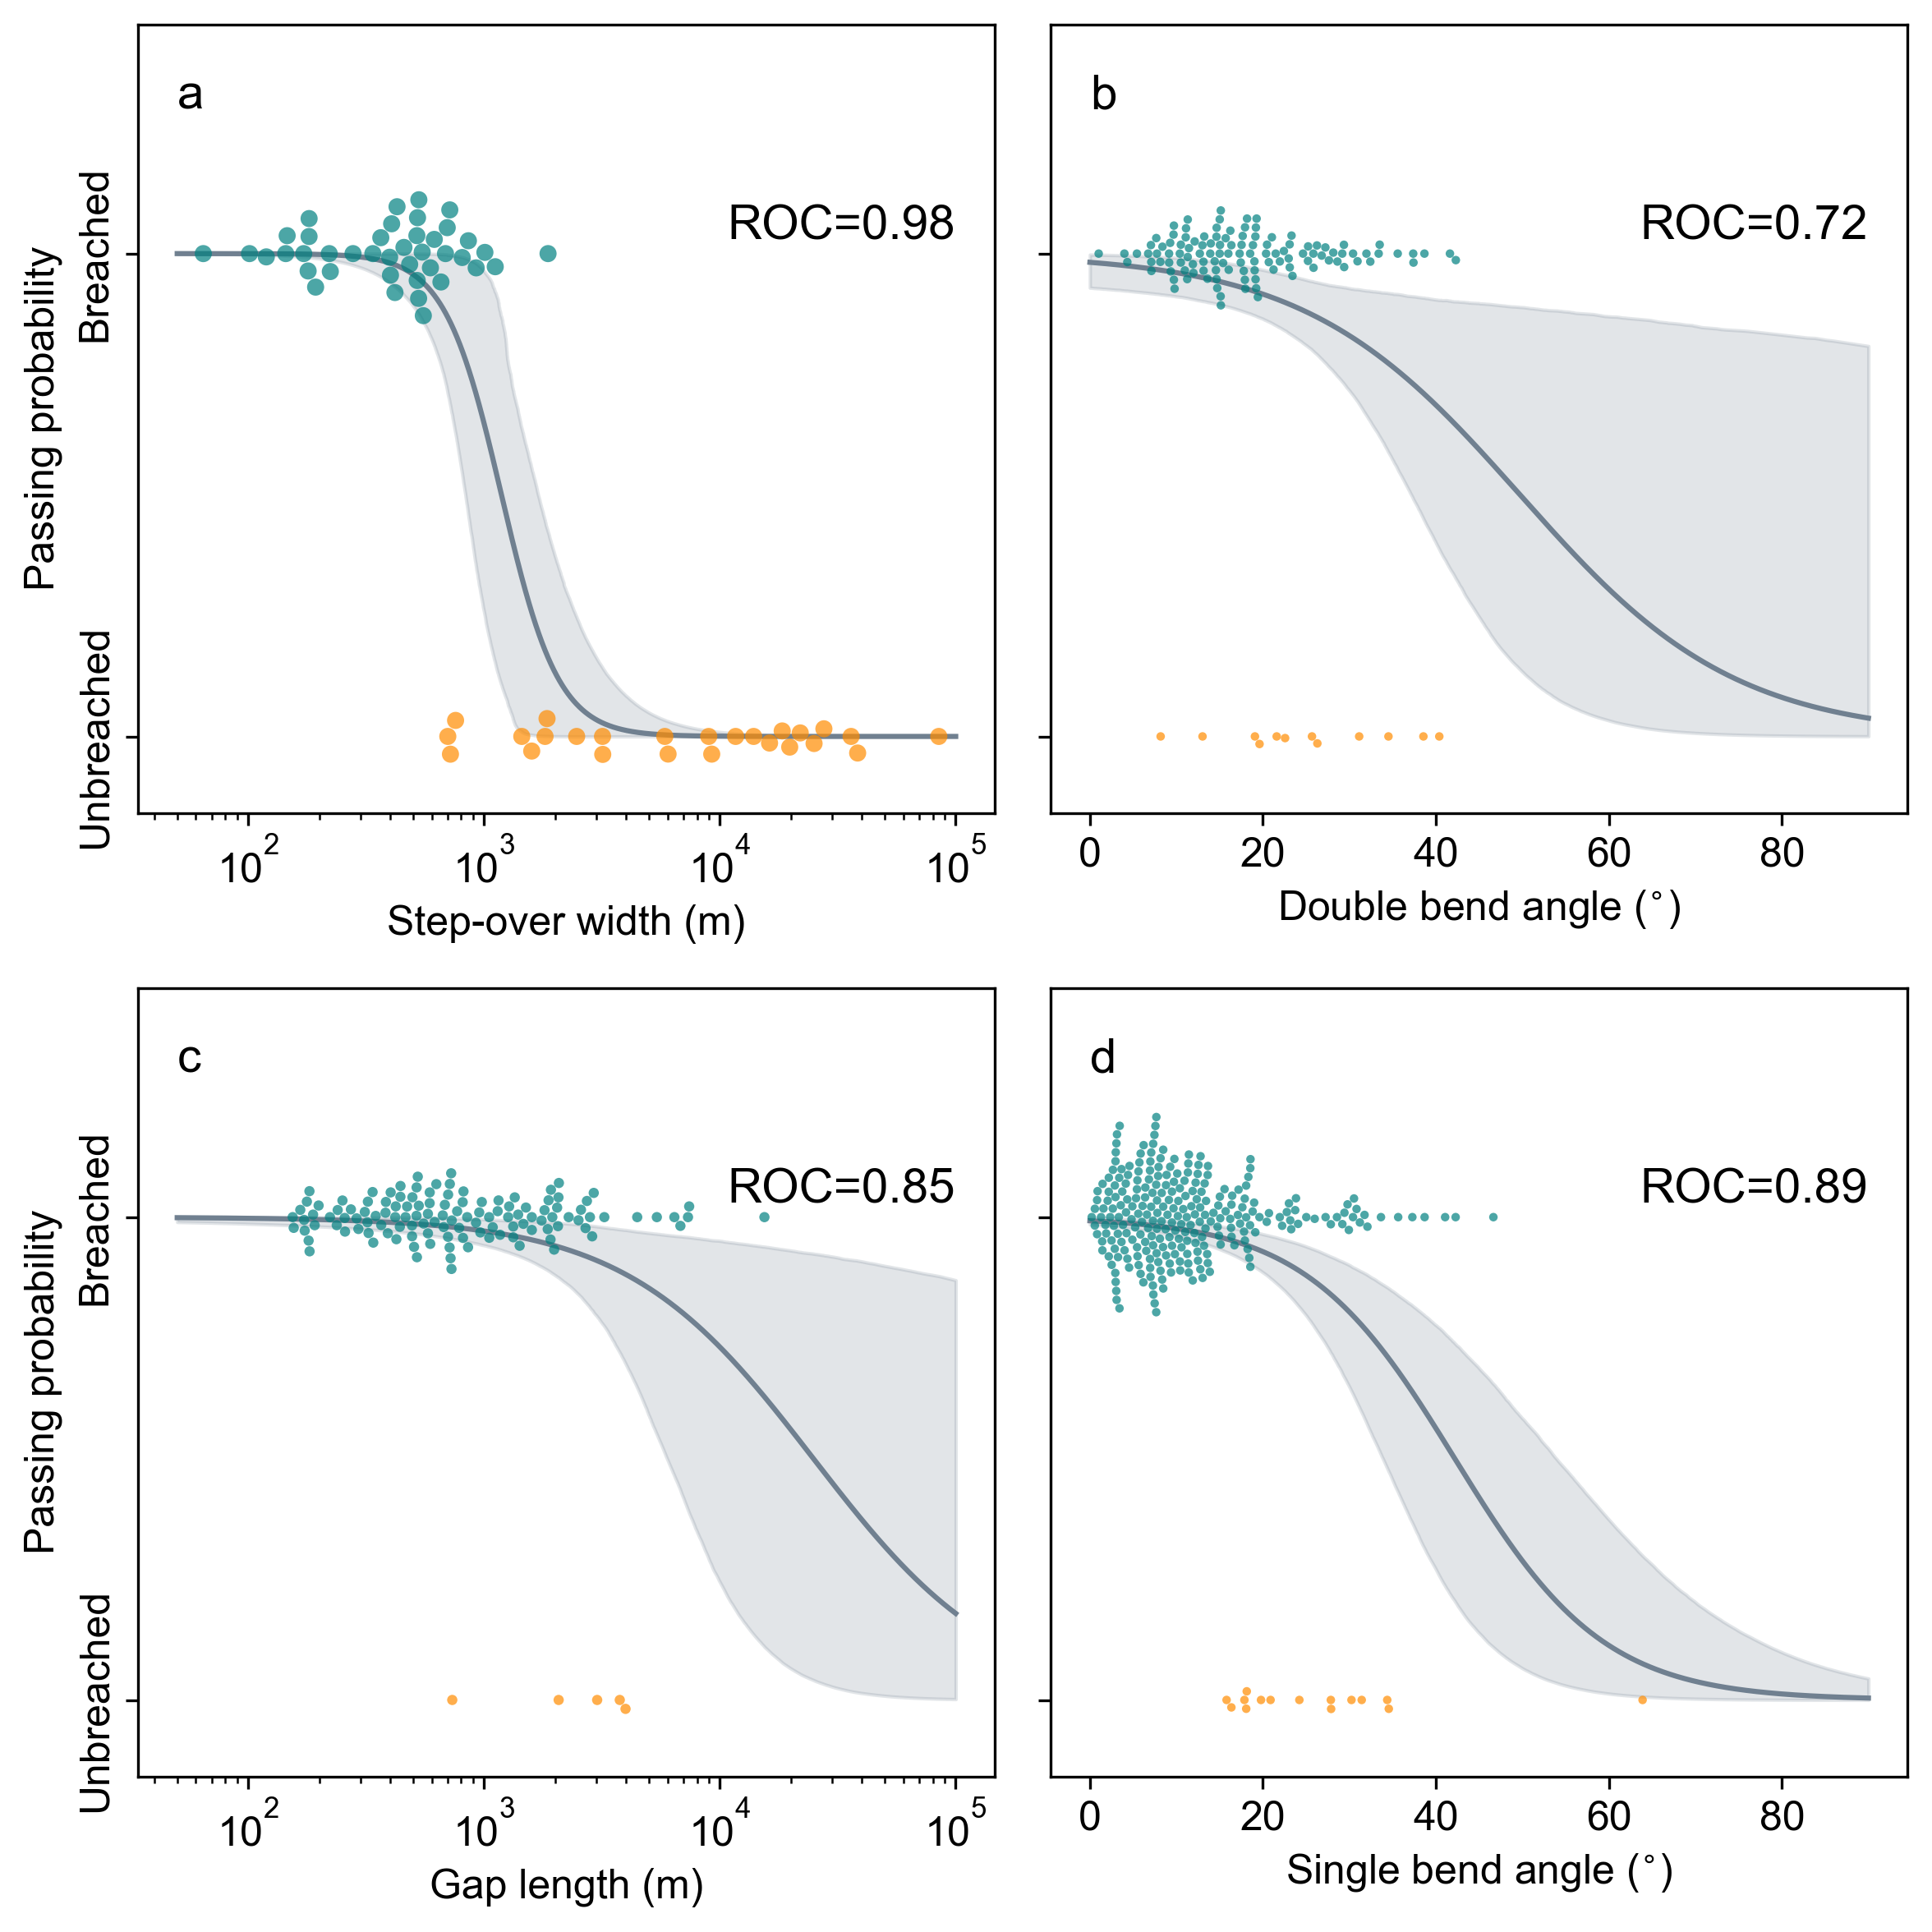

In [ ]:
condition = ~((data["Breached or unbreached"] == 'unbreached') & 
              (data['Normalized location'] > 0.05) & 
              (data['Normalized location'] < 0.95))

data_nounbreached_middle = data[condition]
grouped = data_nounbreached_middle.groupby(data_nounbreached_middle.Feature)

fig, axes = plt.subplots(2,2,figsize=(8,8), sharey=True, dpi=300)
 
build_logistic_regression(
    grouped,
    'stepover', 
    'none', 
    'length', 
    None, 
    axes[0,0],
    50,
    100000,
    'slategrey',
    'Step-over width (m)',
    5
)

build_logistic_regression(grouped,'bend', 'double', 'angle',None,axes[0,1],0,90,'slategrey','Double bend angle ($^{\circ}$)',2.5)
build_logistic_regression(grouped,'bend', 'single', 'angle', None,
                                    axes[1,1],0,90,'slategrey','Single bend angle ($^{\circ}$)',2.5)
build_logistic_regression(grouped,'gap', 'none', 'length', None, axes[1,0],50,100000,'slategrey','Gap length (m)',3)


# add labels
axes[0,0].text(50,-0.3,'a',fontsize=14)
axes[0,1].text(0,-0.3,'b',fontsize=14)
axes[1,0].text(50,-0.3,'c',fontsize=14)
axes[1,1].text(0,-0.3,'d',fontsize=14)

plt.tight_layout()
plt.savefig('GRL/PP_EQgates_nounbreached_middle.pdf')
plt.show()